### Recordatorio:
- Debes ejecutar la siguiente celda para poder jugar con lo que tenemos preparado
- Para ejecutar una celda la tienes que seleccionar y pulsar: Ctrl + Enter (Shift + Enter también vale)
- Cuando la hayas ejecutado, para iniciar el modo presentación teclea: alt + R
- Con las teclas de AvPág y RePág, adelantas o retrocedes en la presentación
- En Chrome puedes habilitar el modo a pantalla completa con: F11
- Para salir del modo presentación vuelve a teclear: alt + R

In [2]:
#@title Módulos (o librerías, o paquetes) que hay que cargar previamente
# Si no ejecutas esta celda no vas a poder interactuar con las celdas que vendrán a continuación
from IPython.display import IFrame
from IPython.display import Image
from IPython.display import Audio
from IPython.display import YouTubeVideo
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:85% !important; }</style>"))
js = "<script>hoy = new Date();var eta_ms = new Date(hoy.getFullYear(), hoy.getMonth(), hoy.getDate(), 19, 13).getTime() - Date.now();var timeout = setTimeout(function(){alert('Héctor, quizá podrías dejar tranquilita ya a la gente, ¿no? Gracias :)');}, eta_ms);</script>"
display(HTML(js))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
import matplotlib.mlab as ml
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from ipywidgets import interactive
import scipy.io.wavfile as wavfile # sirve para leer ficheros WAV: https://docs.scipy.org/doc/scipy/reference/tutorial/io.html#module-scipy.io.wavfile
import scipy.signal as sig # hilbert, espectrograma, chirp
import pywt # sirve para la transformada de wavelet: pip install PyWavelets
import pandas as pd
import urllib.request
import warnings
warnings.filterwarnings('ignore')
class displayhoriz(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">{1}</div>"""
    def __init__(self, *args):
        self.args = args
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

# Tema 4.- Análisis temporal y frecuencial

* Señales:
  * Concepto y magnitudes
  * Clasificación
  * Cuantificación en el dominio de la amplitud
* Técnicas en dominio tiempo:
  * Función de autocorrelación
  * Función de correlación cruzada
  * Transformada de Hilbert
* Técnicas en dominio frecuencia:
  * Análisis de Fourier
  * Enventanado
  * Suavizado y filtrado


## Objetivos:

* Presentar los fundamentos del procesado de señal como herramienta necesaria para el diagnóstico
*  Formalizar conceptos y técnicas ya vistos de forma superficial en temas anteriores
* Aprender a realizar las siguientes operaciones con ayuda de un ordenador:
  * La función de autocorrelación de una señal
  * La transformada de Hilbert de una señal
  * La transformada de Fourier de una señal
  * Filtrado de señales: pasa-baja, pasa-banda, y pasa-alta
  * Comprender el fenómeno de fugas y cómo evitarlo con el enventanado


## Señales

**Concepto**

Representación de cualquier fenómeno físico en función de una variable.

Variable:
* Magnitud física utilizada para la descripción de una señal
* La variable más empleada es el tiempo
* También se puede utilizar otras como la longitud, ángulo, volumen, etc.

### Magnitudes

Señal:
$$x \left( t \right)$$    

Potencia:
$$P \left[ x \left( t \right) \right] = x^2 \left( t \right)$$    

Energía:
$$E \left[ x \left( t \right) \right] = \int_{-\infty}^{+\infty} x^2 \left( t \right) \mathrm{d}t$$    


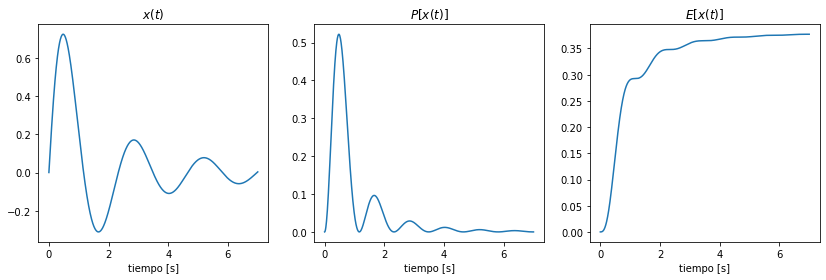

In [ ]:
#@title En esta celda nos inventamos una señal y calculamos su potencia y energía: y graficamos todo
t = np.linspace(0,7,1000)
dt = t[1] - t[0]
x = np.sin(2*np.pi*0.43*t) / (t**1.5+1) # una señal cualquiera
pot = x ** 2 # cálculo de la potencia
en = np.cumsum(pot * dt) # cálculo de la energía
fig = plt.figure(figsize=(14, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(t,x)
ax1.set_xlabel('tiempo [s]'), ax1.set_title('$x(t)$')
ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(t,pot)
ax2.set_xlabel('tiempo [s]'), ax2.set_title('$P[x(t)]$')
ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(t,en)
ax3.set_xlabel('tiempo [s]'), ax3.set_title('$E[x(t)]$');

### Clasificación
* Señales deterministas
* Señales aleatorias

#### Señales deterministas

* Se describen mediante una relación matemática explícita
* Predicción precisa de su valor en instante futuro
* Ejemplos
  * Vibración en una máquina rotativa desequilibrada
  * Fluctuación de presión en los conductos de admisión o escape de un motor de combustión interna alternativo (MCIA)

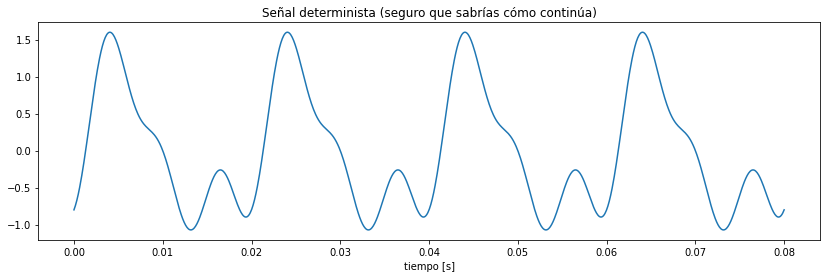

In [ ]:
#@title Ejemplo de señal determinista
# xdet(tdet)
tmax = 0.08 # segundos
f = 50 # Hz
tdet = np.linspace(0,tmax,1000)
xdet = np.sin(2*np.pi*f*tdet) + 0.4 * np.sin(2*np.pi*2*f*tdet+1.5*np.pi) + 0.4 * np.sin(2*np.pi*3*f*tdet+1.5*np.pi) # una señal determinista
fig = plt.figure(figsize=(14, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(tdet,xdet)
ax1.set_xlabel('tiempo [s]'), ax1.set_title('Señal determinista (seguro que sabrías cómo continúa)');

#### Señales aleatorias

* Sin relación matemática explícita ni predicción de valor futuro
* Descritas por valoraciones probabilísticas y métodos estadísticos
* Ejemplos
  * Vibración de los ejes de las ruedas de un vehículo
  * Ruido producido por el proceso de combustión


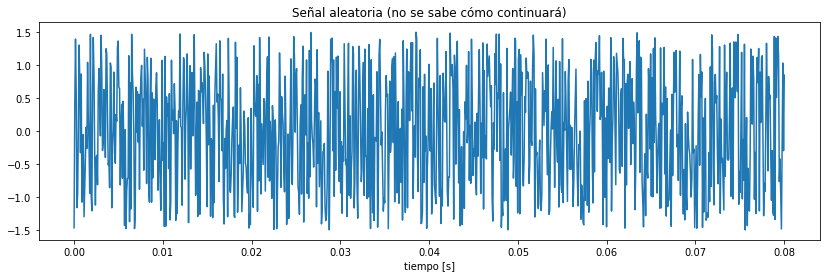

In [ ]:
#@title Ejemplo de señal aleatoria
# xale(tale)
tale = np.linspace(0,0.08,1000)
xale = 3 * (np.random.rand(*tale.shape)-0.5) # una señal aleatoria con las mismas dimensiones que "tale"
fig = plt.figure(figsize=(14, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(tale,xale)
ax1.set_xlabel('tiempo [s]'), ax1.set_title('Señal aleatoria (no se sabe cómo continuará)');

## Técnicas para el procesado de señales

* Cuantificación en el dominio de la amplitud
* Análisis en el dominio del tiempo
* Análisis en el dominio de la frecuencia

### Cuantificación en el dominio de la amplitud
<a href="https://en.wikipedia.org/wiki/Mean_of_a_function">Valor medio</a>:

* Promedio de los valores de amplitud de las muestras contenidas en un registro
* Denominado también: momento de primer orden
* Describe el componente estático de un registro

$$ \bar{x} = \frac{1}{T}\int\limits_{0}^{T} x(t) \, \mathrm{d}t = \frac{1}{N}\sum\limits_{n=0}^{N-1} x_n$$    

<a href="https://en.wikipedia.org/wiki/Mean_of_a_function">Valor cuadrático medio</a>:
* Promedio del cuadrado de la amplitud de las muestras contenidas en un registro
* Denominado también: momento de segundo orden
* Da idea de la intensidad de la señal

$$ \bar{x^2} = \frac{1}{T}\int\limits_{0}^{T} \left[ x(t) \right] ^2 \, \mathrm{d}t = \frac{1}{N}\sum\limits_{n=0}^{N-1} x_n^2$$

* A su raíz cuadrada se denomina valor <a href="https://en.wikipedia.org/wiki/Root_mean_square">RMS</a>

$$ x_{RMS} = \sqrt{ \frac{1}{T}\int\limits_{0}^{T} \left[ x(t) \right] ^2 \, \mathrm{d}t }= \sqrt{\frac{1}{N}\sum\limits_{n=0}^{N-1} x_n^2}$$


La <a href="https://en.wikipedia.org/wiki/Variance">Varianza</a>:

* Una señal aleatoria se puede expresar como una composición de un componente estático (valor medio) y un componente dinámico (fluctuaciones alrededor de la media)
* La varianza es el valor cuadrático medio del componente dinámico de la señal
* Denominada también: momento central de segundo orden

$$ \sigma_x^2 = \frac{1}{T}\int\limits_{0}^{T} \left[ x(t)-\bar{x} \right]^2 \, \mathrm{d}t = \frac{1}{N}\sum\limits_{n=0}^{N-1} \left( x_n - \bar{x} \right)^2$$

La <a href="https://en.wikipedia.org/wiki/Standard_deviation">desviación típica</a> es la raíz cuadrada de la varianza


#### Límites en el dominio de la amplitud

- Imagina que se pretende detectar anomalías en una máquina (anomaly detection)
- Estrategia:
    - Se coloca un sistema cerca de la máquina y, cada cierto tiempo, se hace una grabación del ruido.
    - El sistema de forma automática calcula las estadísticas descritas anteriormente y las envía a un servidor.
    - El servidor almacena los datos de forma que disponemos un histórico de estas métricas.
    - Se programan alarmas si se detectan desviaciones en los valores actuales respecto a los pasados.
- ¿Parece una buena estrategia, no? Cuidado, podría no serlo.
    - El siguiente ejemplo está llevado al límite pero sirve para entender que hay que tener cuidado.

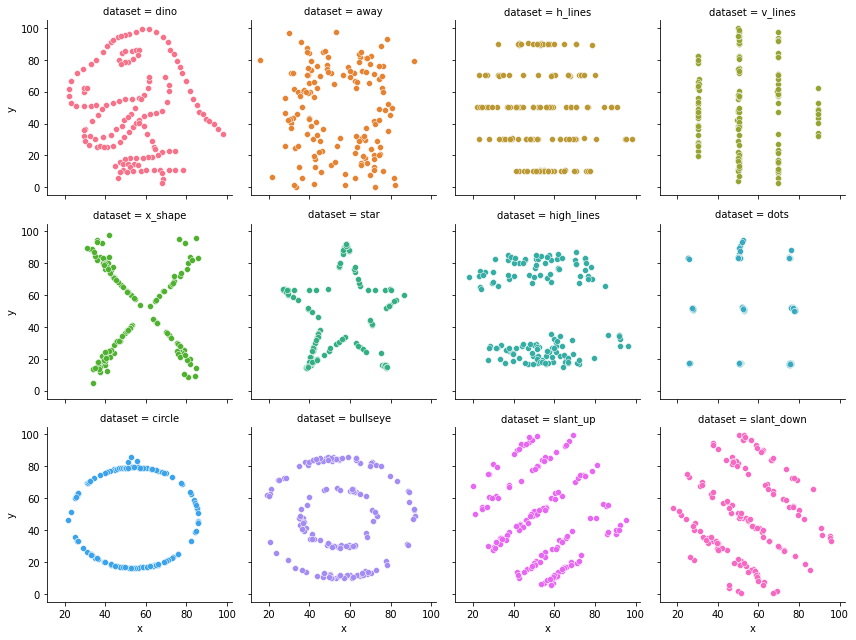

In [ ]:
#@title Diferentes "medidas"
# Descarga en el ordenador el audio
fichin = urllib.request.urlopen('https://hcliment.webs.upv.es/docencia/dar/sounds/tema04/DatasaurusDozen.tsv') # descarga el fichero de Internet
with open('DatasaurusDozen.tsv','wb') as fichout:
    fichout.write(fichin.read()) # guarda el fichero en el ordenador
data = pd.read_csv('DatasaurusDozen.tsv', sep='\t')

import seaborn as sns
grid_scatterplots = sns.FacetGrid(data, col="dataset", hue="dataset", col_wrap=4)
grid_scatterplots.map_dataframe(sns.scatterplot, x="x", y="y")

In [ ]:
#@title Calculemos las estadísticas
def rms(values):
    return np.sqrt(sum(values**2)/len(values))
datasets_grouped = data.groupby('dataset')
datastats = datasets_grouped.agg(['count', 'mean', 'var', 'std'])
datastats['RMSx'] = data.groupby('dataset')["x"].apply(rms)
datastats['RMSy'] = data.groupby('dataset')["y"].apply(rms)
datastats

x                                       y             \
           count       mean         var        std count       mean   
dataset                                                               
away         142  54.266100  281.227029  16.769825   142  47.834721   
bullseye     142  54.268730  281.207393  16.769239   142  47.830823   
circle       142  54.267320  280.898024  16.760013   142  47.837717   
dino         142  54.263273  281.069988  16.765142   142  47.832253   
dots         142  54.260303  281.156953  16.767735   142  47.839829   
h_lines      142  54.261442  281.095333  16.765898   142  47.830252   
high_lines   142  54.268805  281.122364  16.766704   142  47.835450   
slant_down   142  54.267849  281.124206  16.766759   142  47.835896   
slant_up     142  54.265882  281.194420  16.768853   142  47.831496   
star         142  54.267341  281.197993  16.768959   142  47.839545   
v_lines      142  54.269927  281.231512  16.769959   142  47.836988   
x_shape      142  54.260150  281.231481  16.769958   142  47.839717   

                                        RMSx       RMSy  
                   var        std                        
dataset                                                  
away        725.749775  26.939743  56.780773  54.852524  
bullseye    725.533372  26.935727  56.783115  54.847166  
circle      725.226844  26.930036  56.779062  54.850404  
dino        725.515961  26.935403  56.776698  54.848255  
dots        725.235215  26.930192  56.774620  54.852322  
h_lines     725.756931  26.939876  56.775169  54.848692  
high_lines  725.763490  26.939998  56.782443  54.853284  
slant_down  725.553749  26.936105  56.781545  54.851775  
slant_up    725.688605  26.938608  56.780279  54.849158  
star        725.239695  26.930275  56.781705  54.852114  
v_lines     725.638809  26.937684  56.784470  54.853497  
x_shape     725.224991  26.930002  56.775126  54.852131

### Técnicas en dominio tiempo

**Función de autocorrelación**

* Describe la dependencia general de los valores de una señal en dos instantes de tiempo distintos

$$ R_x \left( \tau \right) = \lim_{T \rightarrow 0} \frac{1}{T} \int\limits_{0}^{T} x \left( t \right) \, x \left( t+\tau \right) \, \mathrm{d}t$$

* Propiedades básicas:
  * Es simétrica: $R_x(-\tau) = R_x(\tau)$
  * Presenta su máximo en el origen: $R_x(0) \geq R_x(\tau) \; \forall \tau $
* Aplicaciones:
  * Establecimiento de la influencia de los valores en un instante de tiempo con los de instantes futuros
  * Detección de eco
  * Detección de patrones repetitivos enmascarados con ruido aleatorio


#### Autocorrelación

Una visualización vale más que mil palabras

<small>NOTA: No hace falta que se entienda el código que hay en las siguientes celdas relacionadas con esta visualización de la función de autocorrelación.</small>

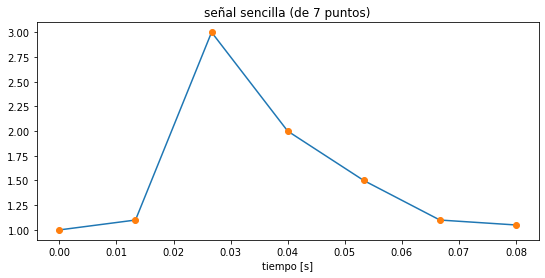

In [ ]:
#@title Creamos una señal muy sencilla:
puntos = 7
tmax = 0.08
tiempo = np.linspace(0,tmax,puntos)
tiempoextendido = np.linspace(-tmax/2,1.5*tmax,2*puntos-1)
senyal = np.array([1, 1.1, 3, 2, 1.5, 1.1, 1.05])
# Vamos a graficarla:
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(tiempo,senyal)
ax1.plot(tiempo,senyal,'o')
titulo = 'señal sencilla (de {} puntos)'.format(puntos)
ax1.set_xlabel('tiempo [s]'), ax1.set_title(titulo);

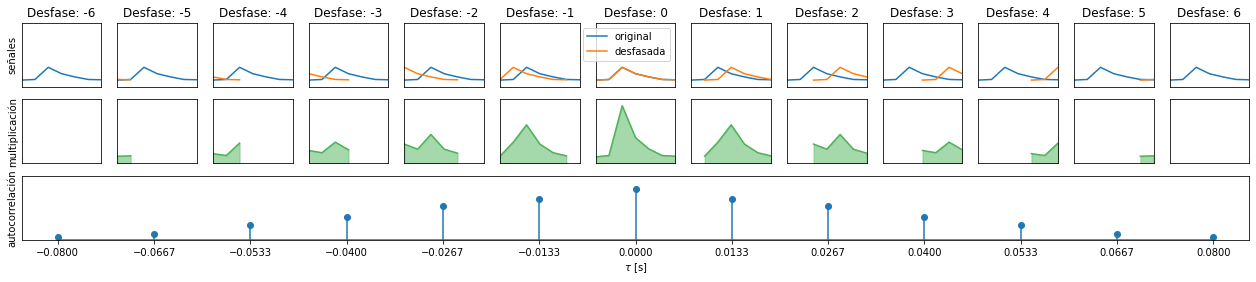

In [ ]:
#@title Visualización de la autocorrelación
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(22, 4))
gs = gridspec.GridSpec(3, puntos*2-1)
senyalextendida = np.pad(senyal,(puntos//2,puntos//2), 'constant', constant_values=np.nan)
plotnum = 0
for desf in range(-puntos+1, puntos):
    senyaldesfasada = np.roll(senyalextendida,desf)
    ax1 = fig.add_subplot(gs[0, plotnum])
    ax2 = fig.add_subplot(gs[1, plotnum])
    plotnum += 1
    ax1.plot(tiempoextendido, senyalextendida, label='original')
    ax1.plot(tiempoextendido, senyaldesfasada, label='desfasada')
    ax1.set_xlim([0,tmax])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_ylim([0,10])
    ax1.set_title('Desfase: '+str(desf))
    ax2.plot(tiempoextendido, senyalextendida * senyaldesfasada, c=(0.3, 0.7, 0.35, 1))
    ax2.fill_between(tiempoextendido, senyalextendida * senyaldesfasada, y2=0, color=(0.3, 0.7, 0.35, 0.5))
    ax2.set_xlim([0,tmax])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_ylim([0,10])
    if plotnum == 1:
        ax1.set_ylabel('señales')
        ax2.set_ylabel('multiplicación')
    if plotnum == puntos:
        ax1.legend()
    
autosenyal = np.correlate(senyal, senyal, 'full')
ax3 = fig.add_subplot(gs[2, :])
ax3.stem(np.linspace(-tmax,tmax,2*puntos-1), autosenyal)
ax3.set_xlim([-tmax-0.005,tmax+0.005])
ax3.set_ylim([0,25])
ax3.set_yticks([])
ax3.set_xticks(np.linspace(-tmax,tmax,2*puntos-1))
ax3.set_ylabel('autocorrelación')
ax3.set_xlabel(r'$\tau$ [s]');


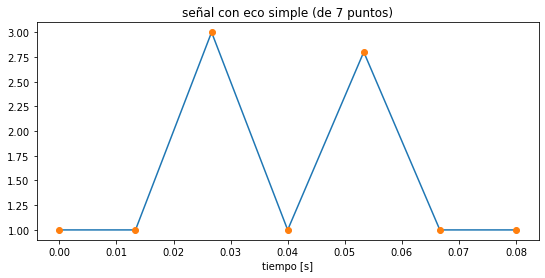

In [ ]:
#@title Creamos una señal con eco muy simple:
puntos = 7
tmax = 0.08
tiempo = np.linspace(0,tmax,puntos)
tiempoextendido = np.linspace(-tmax/2,1.5*tmax,2*puntos-1)
senyal = np.array([1, 1, 3, 1, 2.8, 1, 1])
# Vamos a graficarla:
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(tiempo,senyal)
ax1.plot(tiempo,senyal,'o')
titulo = 'señal con eco simple (de {} puntos)'.format(puntos)
ax1.set_xlabel('tiempo [s]'), ax1.set_title(titulo);

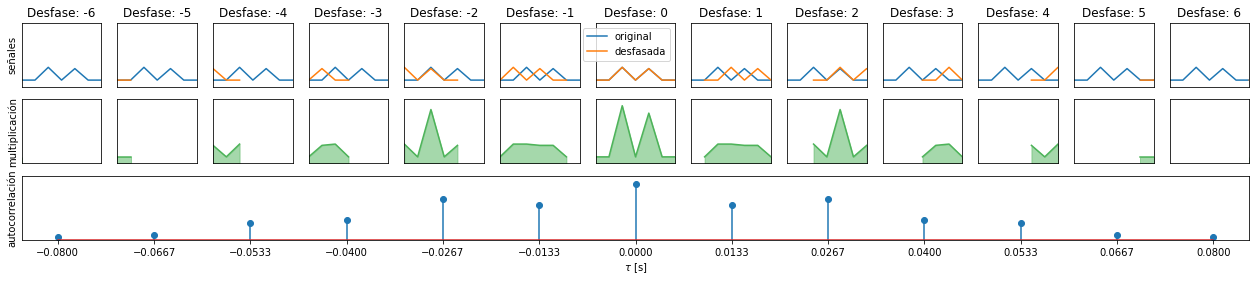

In [ ]:
#@title Visualización de la autocorrelación
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(22, 4))
gs = gridspec.GridSpec(3, puntos*2-1)
senyalextendida = np.pad(senyal,(puntos//2,puntos//2), 'constant', constant_values=np.nan)
plotnum = 0
for desf in range(-puntos+1, puntos):
    senyaldesfasada = np.roll(senyalextendida,desf)
    ax1 = fig.add_subplot(gs[0, plotnum])
    ax2 = fig.add_subplot(gs[1, plotnum])
    plotnum += 1
    ax1.plot(tiempoextendido, senyalextendida, label='original')
    ax1.plot(tiempoextendido, senyaldesfasada, label='desfasada')
    ax1.set_xlim([0,tmax])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_ylim([0,10])
    ax1.set_title('Desfase: '+str(desf))
    ax2.plot(tiempoextendido, senyalextendida * senyaldesfasada, c=(0.3, 0.7, 0.35, 1))
    ax2.fill_between(tiempoextendido, senyalextendida * senyaldesfasada, y2=0, color=(0.3, 0.7, 0.35, 0.5))
    ax2.set_xlim([0,tmax])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_ylim([0,10])
    if plotnum == 1:
        ax1.set_ylabel('señales')
        ax2.set_ylabel('multiplicación')
    if plotnum == puntos:
        ax1.legend()
    
autosenyal = np.correlate(senyal, senyal, 'full')
ax3 = fig.add_subplot(gs[2, :])
ax3.stem(np.linspace(-tmax,tmax,2*puntos-1), autosenyal)
ax3.set_xlim([-tmax-0.005,tmax+0.005])
ax3.set_ylim([0,25])
ax3.set_yticks([])
ax3.set_xticks(np.linspace(-tmax,tmax,2*puntos-1))
ax3.set_ylabel('autocorrelación')
ax3.set_xlabel(r'$\tau$ [s]');


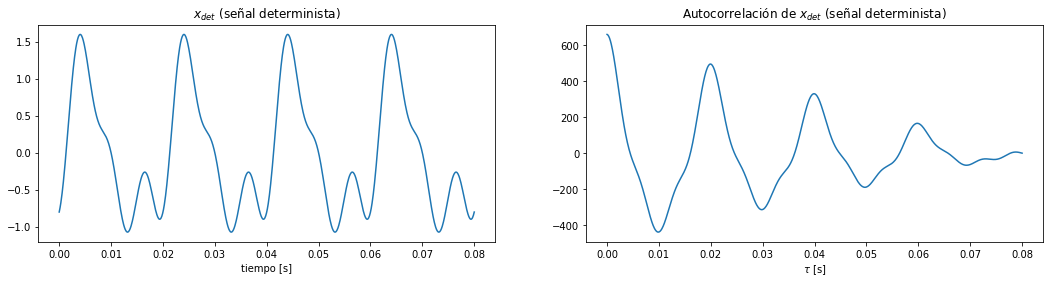

In [ ]:
#@title Cálculo de la función de autocorrelación de una señal determinista
autoxdet = sig.correlate(xdet, xdet, 'full')
fig = plt.figure(figsize=(18, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(tdet,xdet)
ax1.set_xlabel('tiempo [s]'), ax1.set_title('$x_{det}$ (señal determinista)');
ax2 = fig.add_subplot(1, 2, 2)
puntos = len(tdet)
# ax2.plot(tdet,autoxdet[puntos-1:])
ax2.plot(tdet,autoxdet[puntos-1:])
ax2.set_xlabel(r'$\tau$ [s]'), ax2.set_title('Autocorrelación de $x_{det}$ (señal determinista)');

**Preguntas que deberíamos hacernos**

* ¿Cuál es el valor de $\tau$ para el que la función de autocorrelación es máximo?
* ¿Por qué el valor a 0.02 segundos (o 0.04, o 0.06) no son máximos si la señal es periódica?
* ¿Qué frecuencia corresponde con $\tau$ = 0.02?

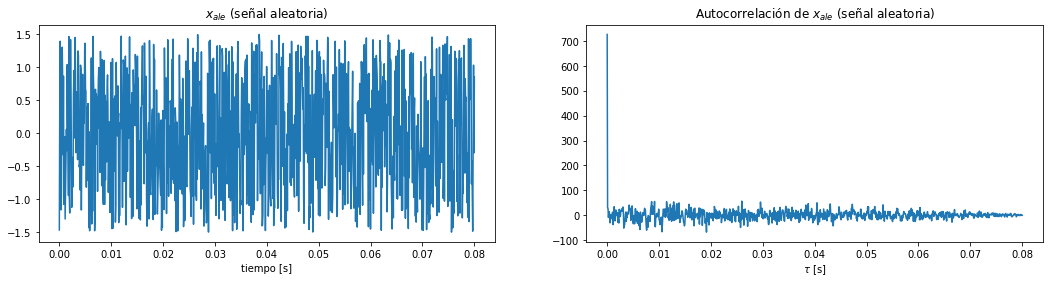

In [ ]:
#@title Cálculo de la función de autocorrelación de una señal aleatoria
autoxale = sig.correlate(xale, xale, 'full')
fig = plt.figure(figsize=(18, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(tale,xale)
ax1.set_xlabel('tiempo [s]'), ax1.set_title('$x_{ale}$ (señal aleatoria)');
ax2 = fig.add_subplot(1, 2, 2)
puntos = len(tale)
ax2.plot(tale,autoxale[puntos-1:])
ax2.set_xlabel(r'$\tau$ [s]'), ax2.set_title('Autocorrelación de $x_{ale}$ (señal aleatoria)');

**Preguntas que deberíamos hacernos**

* ¿Cuál es el valor de $\tau$ para el que la función de autocorrelación es máximo?
* ¿Por qué en este caso la función de autocorrelación proporciona valores muy bajos en $\tau \neq 0$?

#### Función de correlación cruzada

* Describe la dependencia general de los valores de una señal en un instante de tiempo con los valores de otra señal en otro instante distinto

$$ R_{xy} \left( \tau \right) = \lim_{T \rightarrow 0} \frac{1}{T} \int\limits_{0}^{T} x \left( t \right) \, y \left( t+\tau \right) \, \mathrm{d}t$$

* Propiedades básicas:
  * Es simétrica: $R_{xy}(-\tau) = R_{xy}(\tau)$

* Aplicaciones:
  * Cuantificación de retrasos en medidas en diferentes ubicaciones
  * Detección de relaciones causa-efecto entre variables


#### Transformada de <a href="https://en.wikipedia.org/wiki/Hilbert_transform">Hilbert</a>

Es un operador lineal que toma una función, $x(t)$ de una variable real y devuelve otra función también de variable real dado por $H(x)(t)$. Este operador lineal viene dado por la convolución con la función $1/\pi t$

$$ H \left( x \right)\left( t \right) = \frac{1}{\pi} \int\limits_{-\infty}^{\infty} \frac{x \left( \tau \right)}{t - \tau} \, \mathrm{d}\tau$$

Aplicaciones:
* Obtener la envolvente de una señal


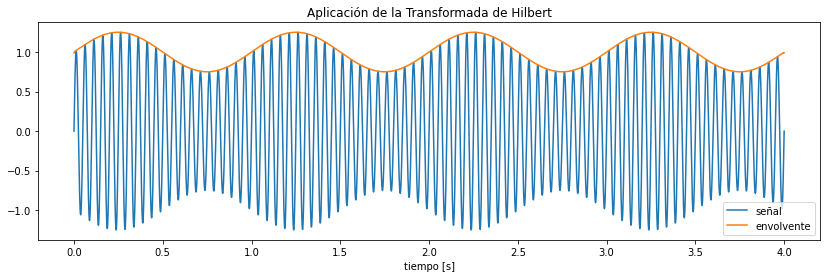

In [ ]:
#@title Cálculo de la envolvente de una señal con la Transformada de Hilbert
tmax = 4
fs = 22000
N = fs * tmax
tiempo = np.linspace(0,tmax,N)
# Creación de una señal un seno cuya amplitud oscila con otro seno de menor frecuencia
A0, A1 = 1, 0.25
f0, f1 = 20, 1
senyal = (A0 + A1 * np.sin(2*np.pi*f1*tiempo)) * np.sin(2*np.pi*f0*tiempo)
# Cálculo de la transformada de Hilbert (son números complejos)
senyal_hilb = sig.hilbert(senyal)
# Cálculo de la envolvente (módulo de la transformada de Hilbert)
envolvente = np.abs(senyal_hilb)

fig = plt.figure(figsize=(14, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(tiempo,senyal,label='señal')
ax1.plot(tiempo,envolvente,label='envolvente')
ax1.legend()
ax1.set_xlabel('tiempo [s]'), ax1.set_title('Aplicación de la Transformada de Hilbert');

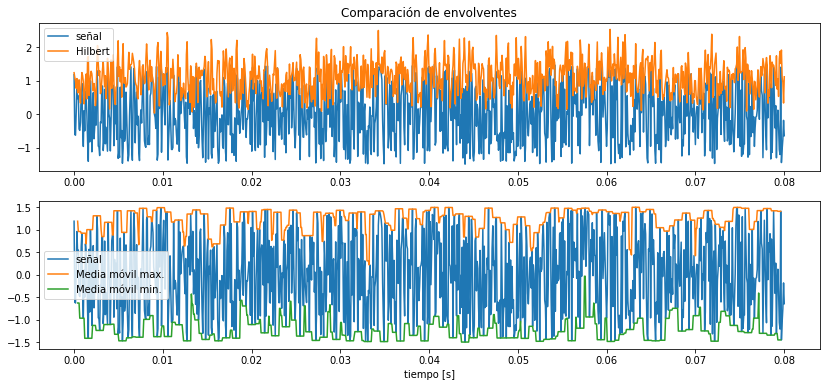

In [31]:
#@title Cálculo de la envolvente con un método alternativo
# https://stackoverflow.com/questions/34235530/how-to-get-high-and-low-envelope-of-a-signal
# Hilbert envelope, also called Energy-Time Curve (ETC), only works well
# for narrow-band fluctuations. Producing an analytic signal, of which you later
# take the absolute value, is a linear operation, so it treats all frequencies
# of your signal equally. If you give it a pure sine wave, it will indeed
# return to you a straight line. When you give it white noise however,
# you will likely get noise back.

tiempo = np.linspace(0,0.08,1000)
senyal = 3 * (np.random.rand(*tiempo.shape)-0.5) # una señal aleatoria con las mismas dimensiones que "tale"
# Cálculo de la transformada de Hilbert (son números complejos)
senyal_hilb = sig.hilbert(senyal)
# Cálculo de la envolvente (módulo de la transformada de Hilbert)
envolvente = np.abs(senyal_hilb)
# Cálculo de la envolvente con el enlace de stackoverflow
df=pd.DataFrame(data={"y":senyal},index=tiempo)
windowsize = 11 # ajusta el tamaño de la ventana móvil
df["y_upperEnv"]=df["y"].rolling(window=windowsize).max().shift(int(-windowsize/2))
df["y_lowerEnv"]=df["y"].rolling(window=windowsize).min().shift(int(-windowsize/2))

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(tiempo,senyal,label='señal')
ax1.plot(tiempo,envolvente,label='Hilbert')
ax2.plot(tiempo,senyal,label='señal')
ax2.plot(df.index,df["y_upperEnv"],label='Media móvil max.')
ax2.plot(df.index,df["y_lowerEnv"],label='Media móvil min.')
ax1.legend()
ax2.legend()
ax2.set_xlabel('tiempo [s]'), ax1.set_title('Comparación de envolventes');

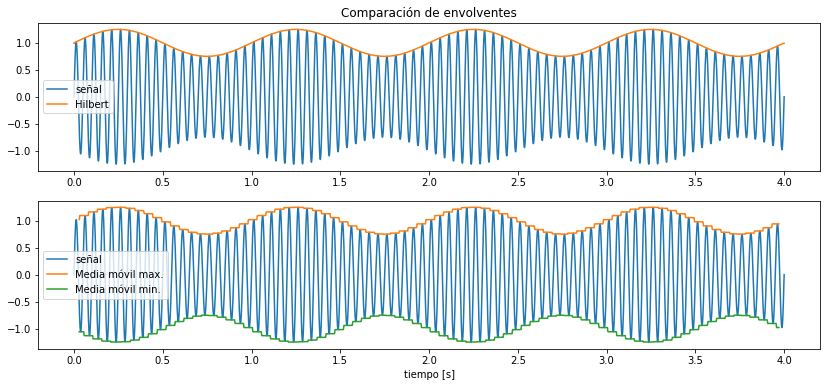

In [44]:
#@title Cálculo de la envolvente con un método alternativo
# https://stackoverflow.com/questions/34235530/how-to-get-high-and-low-envelope-of-a-signal
# Hilbert envelope, also called Energy-Time Curve (ETC), only works well
# for narrow-band fluctuations. Producing an analytic signal, of which you later
# take the absolute value, is a linear operation, so it treats all frequencies
# of your signal equally. If you give it a pure sine wave, it will indeed
# return to you a straight line. When you give it white noise however,
# you will likely get noise back.

tmax = 4
fs = 22000
N = fs * tmax
tiempo = np.linspace(0,tmax,N)
# Creación de una señal un seno cuya amplitud oscila con otro seno de menor frecuencia
A0, A1 = 1, 0.25
f0, f1 = 20, 1
senyal = (A0 + A1 * np.sin(2*np.pi*f1*tiempo)) * np.sin(2*np.pi*f0*tiempo)
# Cálculo de la transformada de Hilbert (son números complejos)
senyal_hilb = sig.hilbert(senyal)
# Cálculo de la envolvente (módulo de la transformada de Hilbert)
envolvente = np.abs(senyal_hilb)
# Cálculo de la envolvente con el enlace de stackoverflow
df=pd.DataFrame(data={"y":senyal},index=tiempo)
windowsize = 1301 # ajusta el tamaño de la ventana móvil
df["y_upperEnv"]=df["y"].rolling(window=windowsize).max().shift(int(-windowsize/2))
df["y_lowerEnv"]=df["y"].rolling(window=windowsize).min().shift(int(-windowsize/2))

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(tiempo,senyal,label='señal')
ax1.plot(tiempo,envolvente,label='Hilbert')
ax2.plot(tiempo,senyal,label='señal')
ax2.plot(df.index,df["y_upperEnv"],label='Media móvil max.')
ax2.plot(df.index,df["y_lowerEnv"],label='Media móvil min.')
ax1.legend()
ax2.legend()
ax2.set_xlabel('tiempo [s]'), ax1.set_title('Comparación de envolventes');

## Técnicas en dominio frecuencia

**Análisis de <a href="https://en.wikipedia.org/wiki/Fourier_analysis">Fourier</a>**

* Análisis continuo: serie de Fourier
* Cualquier señal periódica, de periodo $T_p$, se puede descomponer en un conjunto de componentes senoidales según:

$$ x \left( t \right) = a_0 + \sum_{n=1}^{\infty} \left[ a_n \mathrm{cos}\left(2 n f t \right) + b_n \mathrm{sen}\left(2 n f t \right)\right]$$

donde:
$$ f = \frac{1}{T_p}$$
$$ a_n = \frac{2}{T_p} \int\limits_{0}^{T_p} x \left( t \right) \mathrm{cos}\left(2 n f t \right) \mathrm{d}t$$
$$ b_n = \frac{2}{T_p} \int\limits_{0}^{T_p} x \left( t \right) \mathrm{sin}\left(2 n f t \right) \mathrm{d}t$$


### Análisis de Fourier

**Análisis continuo: transformada de Fourier**

* Análisis frecuencial de señales deterministas transitorias de energía finita
* Transformada directa:

$$ X \left( f \right) = \int\limits_{-\infty}^{\infty} x \left( t \right) e^{-i 2 \pi f t} \mathrm{d}t$$

<small>Ayuda: cuando veas un $e^{i \omega t}$ piensa en un punto girando en un círculo con una frecuencia $\omega$</small>

* Transformada inversa:

$$ x \left( t \right) = \int\limits_{-\infty}^{\infty} X \left( f \right) e^{i 2 \pi f t} \mathrm{d}f$$

<small>Nota: conviene recordar la <a href="https://en.wikipedia.org/wiki/Euler%27s_formula">fórmula de Euler</a>: $e^{ix} = \mathrm{cos}x + i \mathrm{sen}x$</small>


**Análisis discreto: transformada de Fourier discreta (<a href="https://en.wikipedia.org/wiki/Discrete_Fourier_transform">DFT</a>)**

* Análisis frecuencial de señales discretizadas en el dominio temporal (representadas por $N$ muestras en el dominio temporal)
* Transformada directa:

$$ X_k = \frac{1}{N} \sum_{n=0}^{N-1} x_n e^{-i 2 \pi k n/N} \, \mathrm{con} \, k=0, \dots, N-1$$

* Transformada inversa:

$$ x_n = \frac{1}{N} \sum_{k=0}^{N-1} X_k e^{-i 2 \pi k n/N} \, \mathrm{con} \, n=0, \dots, N-1$$


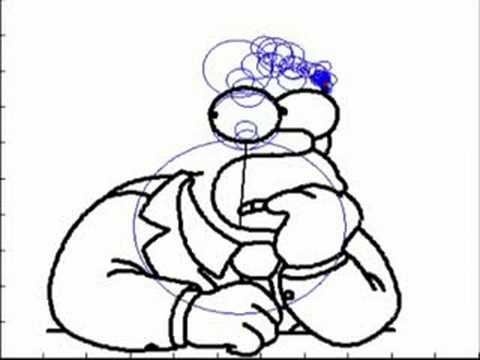

In [ ]:
#@title Toda función periódica puede descomponerse en una serie de cosenos y senos (cada uno de ellos con una amplitud y frecuencia fijas)
# Repito: "toda función periódica"; incluso (spoiler alert!) Homer Simpson :)
vid = YouTubeVideo("QVuU2YCwHjw")
display(vid)

In [ ]:
IFrame('https://isaacvr.github.io/coding/fourier_transform/', 900, 1250)

<h2>Técnicas en dominio frecuencia</h2>
<ul>
    <li>Vamos a trabajar ahora en el notebook</li>
    <li>Mi objetivo es intentar convencerte de que el dominio en frecuencia es muy apropiado para analizar máquinas</li>
    <li>Abandona el modo presentación: Alt+R</li>
</ul>


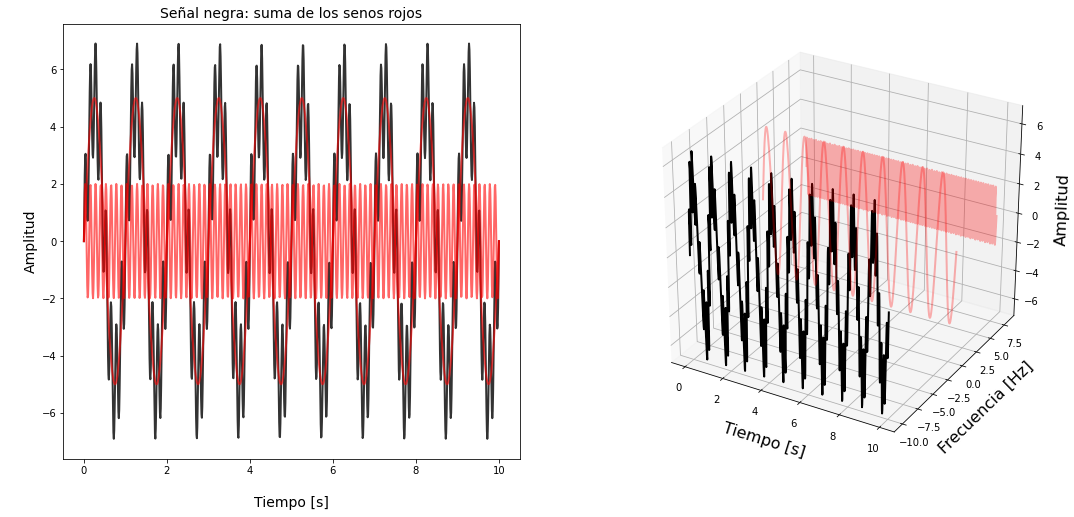

In [ ]:
# A veces es complicado analizar una señal simplemente viendo su evolución temporal:
# ¿te has acordado de ejecutar la segunda celda (arriba del todo)?
tmax = 10
N = 1000
fs = N/tmax
# Esto no funciona en Google Colab %matplotlib notebook
%matplotlib inline

tiempo = np.linspace(0,tmax,N)
senyal = np.zeros([N])
amplitud = [5, 2]
frecuencia = [1, 8]
comp = np.zeros([len(frecuencia),N])
for cont in range(len(frecuencia)):
    comp[cont] = amplitud[cont] * np.sin(2*np.pi*frecuencia[cont]*tiempo)
    senyal = senyal + comp[cont]
    
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(121)
ax1.set_xlabel("\nTiempo [s]", fontsize=14)
ax1.set_ylabel("\nAmplitud", fontsize=14)
ax1.set_title('Señal negra: suma de los senos rojos', fontsize=14)
ax1.plot(tiempo, senyal, linewidth=2, color=(0, 0, 0, 0.8))
for cont in range(len(frecuencia)):
    ax1.plot(tiempo, comp[cont], linewidth=2, color=(1, 0, 0, 0.6))

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_xlabel("\nTiempo [s]", fontsize=16)
ax2.set_ylabel("\nFrecuencia [Hz]", fontsize=16)
ax2.set_zlabel("\nAmplitud", fontsize=16)
ax2.plot(tiempo, -10*np.ones([N]), senyal, linewidth=2, color=(0, 0, 0, 1))
for cont in range(len(frecuencia)):
    ax2.plot(tiempo, frecuencia[cont]*np.ones([N]), comp[cont], linewidth=2, color=(1, 0, 0, 0.3))



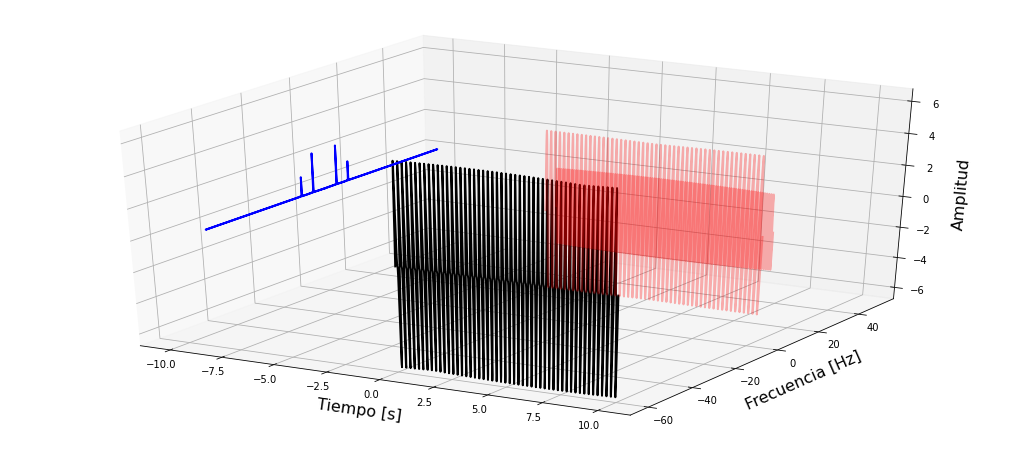

In [ ]:
# Calculemos nuestra primera Transformada de Fourier
tmax = 10
N = 1000
fs = N/tmax
# Esto no funciona en Google Colab %matplotlib notebook
%matplotlib inline

tiempo = np.linspace(0,tmax,N)
senyal = np.zeros([N])
amplitud = [5, 2.5]
frecuencia = [5, 10]
comp = np.zeros([len(frecuencia),N])
for cont in range(len(frecuencia)):
    comp[cont] = amplitud[cont] * np.sin(2*np.pi*frecuencia[cont]*tiempo)
    senyal = senyal + comp[cont]
    
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("\nTiempo [s]", fontsize=16)
ax.set_ylabel("\nFrecuencia [Hz]", fontsize=16)
ax.set_zlabel("\nAmplitud", fontsize=16)
ax.plot(tiempo, -60*np.ones([N]), senyal, linewidth=2, color=(0, 0, 0, 1))
for cont in range(len(frecuencia)):
    ax.plot(tiempo, frecuencia[cont]*np.ones([N]), comp[cont], linewidth=2, color=(1, 0, 0, 0.3))

# La diferencia con la celda anterior está aquí:
tf_senyal = np.fft.fft(senyal)/N
fr_senyal = np.fft.fftfreq(N, 1/fs)

ax.plot(-10*np.ones([N]), fr_senyal, np.abs(tf_senyal), linewidth=2, color=(0, 0, 1, 1));

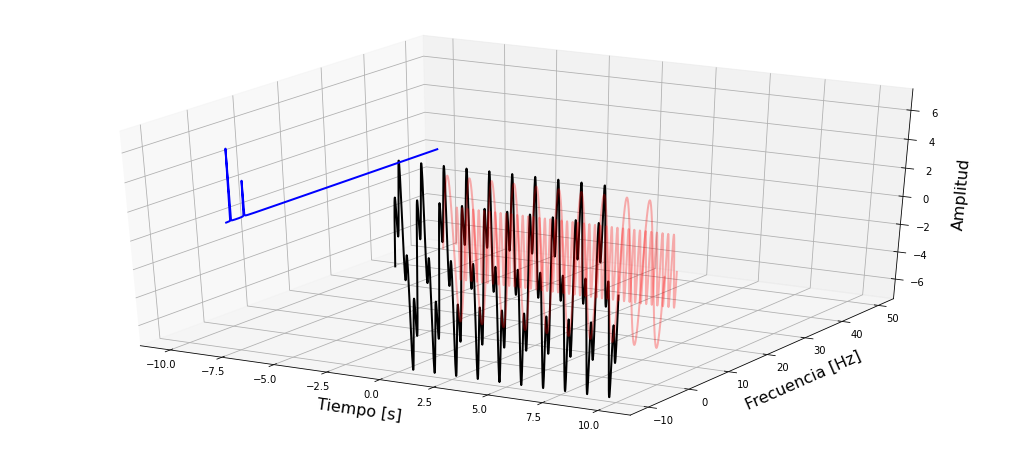

In [ ]:
# Pero lo anterior no es suficiente: hay que hacer alguna pequeña manipulación
tmax = 10
N = 1000
fs = N/tmax
# Esto no funciona en Google Colab %matplotlib notebook
%matplotlib inline

tiempo = np.linspace(0,tmax,N)
senyal = np.zeros([N])
amplitud = [5, 2.5]
frecuencia = [1, 4]
comp = np.zeros([len(frecuencia),N])
for cont in range(len(frecuencia)):
    comp[cont] = amplitud[cont] * np.sin(2*np.pi*frecuencia[cont]*tiempo)
    senyal = senyal + comp[cont]
    
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("\nTiempo [s]", fontsize=16)
ax.set_ylabel("\nFrecuencia [Hz]", fontsize=16)
ax.set_zlabel("\nAmplitud", fontsize=16)
ax.plot(tiempo, -10*np.ones([N]), senyal, linewidth=2, color=(0, 0, 0, 1))
for cont in range(len(frecuencia)):
    ax.plot(tiempo, frecuencia[cont]*np.ones([N]), comp[cont], linewidth=2, color=(1, 0, 0, 0.3))

tf_senyal = np.fft.fft(senyal)/N*2
fr_senyal = np.fft.fftfreq(N, 1/fs)
Nmitad = N//2 if N%2==0 else N//2+1

ax.plot(-10*np.ones([Nmitad]), fr_senyal[0:Nmitad], np.abs(tf_senyal[0:Nmitad]), linewidth=2, color=(0, 0, 1, 1));

<h2>Técnicas en dominio frecuencia</h2>
<h3>Enventanado</h3>
<ul>
    <li>Las <a href="https://en.wikipedia.org/wiki/Window_function">ventanas</a> son funciones matemáticas usadas con frecuencia en el procesado de señales que tienen un valor nulo fuera de un determinado intervalo.</li>
    <li>Hay muchos <a href="https://en.wikipedia.org/wiki/Window_function#A_list_of_window_functions">tipos de ventanas</a>.</li>
    <li>Se usan para...</li>
    <ul>
        <li>garantizar un registro periódico de señales continuas.</li>
        <li>para evitar las discontinuidades al principio y al final de los bloques analizados</li>
    </ul>
</ul>


### Enventanado

Problemática de trabajar con señales finitas:
* Señal periódica: recorte de ciclos completos (izquierda), continuidad razonable en los extremos
* Señal periódica: recorte de ciclos incompletos (derecha), se introduce algo raro en los extremos

<img src="https://hcliment.webs.upv.es/docencia/dar/figs/tema04/PeriodicaNoPeriodica.jpg" alt="drawing" width="600"/>


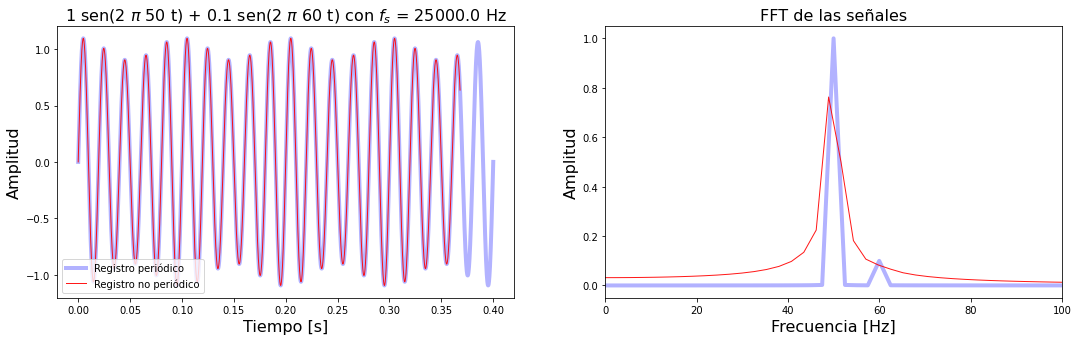

In [ ]:
#@title Fenómeno de fugas (leakage)
tmax = 0.4
N = 10000
fs = N/tmax
%matplotlib inline
# Diseñamos las señales
tiempo = np.linspace(0,tmax,N)
tiemponp = tiempo[0:int(N*0.92)]
Nnp = len(tiemponp)
ampli1, ampli2 = 1, 0.1
frec1, frec2 = 50, 60
senyal = ampli1 * np.sin(2*np.pi*frec1*tiempo) + ampli2 * np.sin(2*np.pi*frec2* tiempo)
senyalnp = ampli1 * np.sin(2*np.pi*frec1*tiemponp) + ampli2 * np.sin(2*np.pi*frec2* tiemponp)
# Calculamos las FFTs
tf_senyal = np.fft.fft(senyal)/N*2
fr_senyal = np.fft.fftfreq(N, 1/fs)
tf_senyalnp = np.fft.fft(senyalnp)/Nnp*2
fr_senyalnp = np.fft.fftfreq(Nnp, 1/fs)
# Graficamos
fig = plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlabel("Tiempo [s]", fontsize=16)
ax1.set_ylabel("Amplitud", fontsize=16)
titulo = r"{} sen(2 $\pi$ {} t) + {} sen(2 $\pi$ {} t) con $f_s$ = {} Hz".format(ampli1, frec1, ampli2, frec2, fs)
ax1.set_title(titulo, fontsize=16)
ax1.plot(tiempo, senyal, linewidth=4, color=(0, 0, 1, 0.3), label='Registro periódico')
ax1.plot(tiemponp, senyalnp, linewidth=1, color=(1, 0, 0, 0.9), label='Registro no periódico')
ax1.legend(loc=3)
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(fr_senyal[0:N//2], np.abs(tf_senyal[0:N//2]), linewidth=4, color=(0, 0, 1, 0.3))
ax2.plot(fr_senyalnp[0:Nnp//2], np.abs(tf_senyalnp[0:Nnp//2]), linewidth=1, color=(1, 0, 0, 0.9))
ax2.set_xlim(0, 100)
ax2.set_title("FFT de las señales", fontsize=16)
ax2.set_xlabel("Frecuencia [Hz]", fontsize=16)
ax2.set_ylabel("Amplitud", fontsize=16);

Posibles consecuencias de no realizar un registro periódico de una señal que sí lo es:
* La energía de la señal se reparte en distintos armónicos.
* Este fenómeno se conoce con el nombre de "fuga" (<a href="https://en.wikipedia.org/wiki/Spectral_leakage">leakage</a>).
* Se pueden producir enmascaramientos de señales pequeñas cercanas a la señal principal &#x1f62e;

<h2>Técnicas en dominio frecuencia</h2>
<h3>Enventanado</h3>
<ul>
    <li>Para evitar el fenómeno de fugas</li>
</ul>

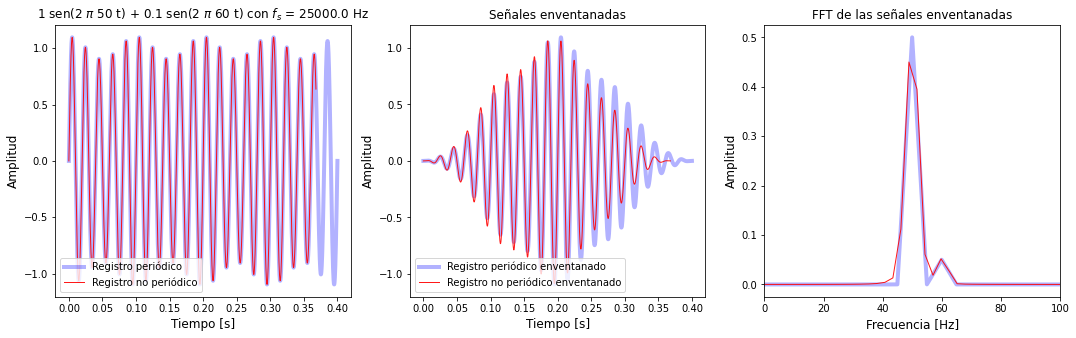

In [ ]:
#@title Aplicación del enventanado
# Se resuelve el problema del leakage
tmax = 0.4
N = 10000
fs = N/tmax
%matplotlib inline
# Diseñamos las señales
tiempo = np.linspace(0,tmax,N)
tiemponp = tiempo[0:int(N*0.92)]
Nnp = len(tiemponp)
ampli1, ampli2 = 1, 0.1
frec1, frec2 = 50, 60
senyal = ampli1 * np.sin(2*np.pi*frec1*tiempo) + ampli2 * np.sin(2*np.pi*frec2* tiempo)
ventana1 = np.hanning(N)
senyalenv = senyal * ventana1
senyalnp = ampli1 * np.sin(2*np.pi*frec1*tiemponp) + ampli2 * np.sin(2*np.pi*frec2* tiemponp)
ventana2 = np.hanning(Nnp)
senyalnpenv = senyalnp * ventana2
# Calculamos las FFTs
tf_senyalenv = np.fft.fft(senyalenv)/N*2
fr_senyalenv = np.fft.fftfreq(N, 1/fs)
tf_senyalnpenv = np.fft.fft(senyalnpenv)/Nnp*2
fr_senyalnpenv = np.fft.fftfreq(Nnp, 1/fs)
# Graficamos
fig = plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_xlabel("Tiempo [s]", fontsize=12)
ax1.set_ylabel("Amplitud", fontsize=12)
titulo = r"{} sen(2 $\pi$ {} t) + {} sen(2 $\pi$ {} t) con $f_s$ = {} Hz".format(ampli1, frec1, ampli2, frec2, fs)
ax1.set_title(titulo, fontsize=12)
ax1.plot(tiempo, senyal, linewidth=4, color=(0, 0, 1, 0.3), label='Registro periódico')
ax1.plot(tiemponp, senyalnp, linewidth=1, color=(1, 0, 0, 0.9), label='Registro no periódico')
ax1.legend(loc=3)
ax2 = fig.add_subplot(1, 3, 2)
ax2.set_xlabel("Tiempo [s]", fontsize=12)
ax2.set_ylabel("Amplitud", fontsize=12)
ax2.set_title("Señales enventanadas")
ax2.plot(tiempo, senyalenv, linewidth=4, color=(0, 0, 1, 0.3), label='Registro periódico enventanado')
ax2.plot(tiemponp, senyalnpenv, linewidth=1, color=(1, 0, 0, 0.9), label='Registro no periódico enventanado')
ax2.legend(loc=3)
ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(fr_senyalenv[0:N//2], np.abs(tf_senyalenv[0:N//2]), linewidth=4, color=(0, 0, 1, 0.3))
ax3.plot(fr_senyalnpenv[0:Nnp//2], np.abs(tf_senyalnpenv[0:Nnp//2]), linewidth=1, color=(1, 0, 0, 0.9))
ax3.set_xlim(0, 100)
ax3.set_title("FFT de las señales enventanadas", fontsize=12)
ax3.set_xlabel("Frecuencia [Hz]", fontsize=12)
ax3.set_ylabel("Amplitud", fontsize=12);

* Al aplicar el enventanado:
  * El registro no periódico se convierte en periódico.
  * El fenómeno de fugas desaparece &#x1f60a;
  * Pero, obviamente, las amplitudes de la señal enventanada no coinciden con la original &#x1f622;
  * Aunque esto último puede <a href="https://community.sw.siemens.com/s/article/window-correction-factors">corregirse</a> teniendo en cuenta la pérdida de la amplitud provocada por la aplicación de la ventana: observa la siguiente celda.

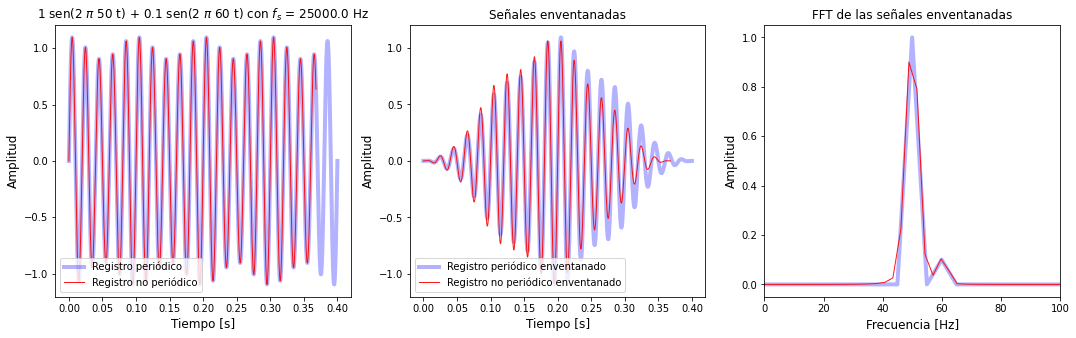

In [ ]:
#@title Resolviendo el problema de fugas y la recuperación de la amplitud de la señal
tmax = 0.4
N = 10000
fs = N/tmax
%matplotlib inline
# Diseñamos las señales
tiempo = np.linspace(0,tmax,N)
tiemponp = tiempo[0:int(N*0.92)]
Nnp = len(tiemponp)
ampli1, ampli2 = 1, 0.1
frec1, frec2 = 50, 60
senyal = ampli1 * np.sin(2*np.pi*frec1*tiempo) + ampli2 * np.sin(2*np.pi*frec2* tiempo)
ventana1 = np.hanning(N)
senyalenv = senyal * ventana1
senyalnp = ampli1 * np.sin(2*np.pi*frec1*tiemponp) + ampli2 * np.sin(2*np.pi*frec2* tiemponp)
ventana2 = np.hanning(Nnp)
senyalnpenv = senyalnp * ventana2
# Calculamos las FFTs
tf_senyalenv = np.fft.fft(senyalenv)/N*2
fr_senyalenv = np.fft.fftfreq(N, 1/fs)
tf_senyalnpenv = np.fft.fft(senyalnpenv)/Nnp*2
fr_senyalnpenv = np.fft.fftfreq(Nnp, 1/fs)
# Graficamos
fig = plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_xlabel("Tiempo [s]", fontsize=12)
ax1.set_ylabel("Amplitud", fontsize=12)
titulo = r"{} sen(2 $\pi$ {} t) + {} sen(2 $\pi$ {} t) con $f_s$ = {} Hz".format(ampli1, frec1, ampli2, frec2, fs)
ax1.set_title(titulo, fontsize=12)
ax1.plot(tiempo, senyal, linewidth=4, color=(0, 0, 1, 0.3), label='Registro periódico')
ax1.plot(tiemponp, senyalnp, linewidth=1, color=(1, 0, 0, 0.9), label='Registro no periódico')
ax1.legend(loc=3)
ax2 = fig.add_subplot(1, 3, 2)
ax2.set_xlabel("Tiempo [s]", fontsize=12)
ax2.set_ylabel("Amplitud", fontsize=12)
ax2.set_title("Señales enventanadas")
ax2.plot(tiempo, senyalenv, linewidth=4, color=(0, 0, 1, 0.3), label='Registro periódico enventanado')
ax2.plot(tiemponp, senyalnpenv, linewidth=1, color=(1, 0, 0, 0.9), label='Registro no periódico enventanado')
ax2.legend(loc=3)
ax3 = fig.add_subplot(1, 3, 3)
Kventana1 = N / np.sum(ventana1)
Kventana2 = Nnp / np.sum(ventana2)
ax3.plot(fr_senyalenv[0:N//2], np.abs(tf_senyalenv[0:N//2])*Kventana1, linewidth=4, color=(0, 0, 1, 0.3))
ax3.plot(fr_senyalnpenv[0:Nnp//2], np.abs(tf_senyalnpenv[0:Nnp//2])*Kventana2, linewidth=1, color=(1, 0, 0, 0.9))
ax3.set_xlim(0, 100)
ax3.set_title("FFT de las señales enventanadas", fontsize=12)
ax3.set_xlabel("Frecuencia [Hz]", fontsize=12)
ax3.set_ylabel("Amplitud", fontsize=12);

#### Suavizado

Técnicas que permiten la medida de señales en presencia de ruido y la medida de ruido propiamente dicho.

* La técnica estadística más empleada es el promediado.
* También se pueden utilizar filtros de Fourier para eliminar el ruido de una señal.
* Se usan para...
  * incrementar la relación señal-ruido de un determinado registro.
  * extraer la información relevante de la respuesta de un sistema, desacoplándola del ruido asociado a la medida.

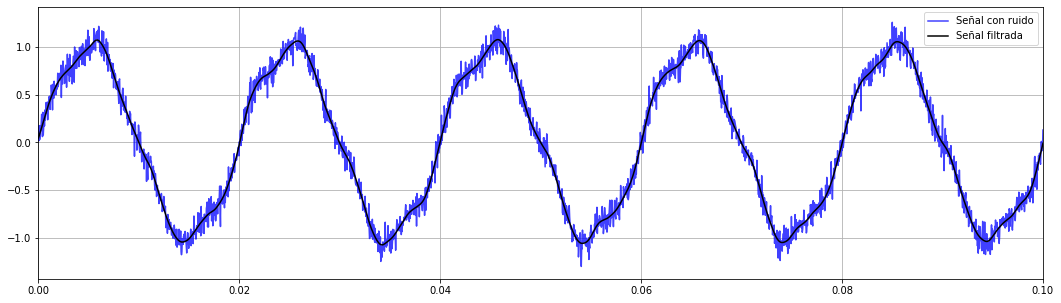

In [ ]:
#@title
# Esta celda sirve para enseñar dos funciones (lfilter y filtfilt) usadas para filtrar una señal
tmax = 0.4
N = 10000
fs = N/tmax
%matplotlib inline
# Diseñamos las señales
tiempo = np.linspace(0,tmax,N)
ampli1, ampli2 = 1, 0.1
frec1, frec2 = 50, 200
senyal = ampli1 * np.sin(2*np.pi*frec1*tiempo) + ampli2 * np.sin(2*np.pi*frec2* tiempo) + np.random.randn(N) * 0.08
# Creación del filtro (pasa-baja en este caso):
b, a = sig.butter(2, 500/(fs/2), 'low') # Atención a la forma de introducir la frecuencia de corte (adimensionalizada con la frecuencia de Nyquist: fs/2)
# Y aplicamos el filtro a la señal temporal
senyalfilt = sig.filtfilt(b, a, senyal)
# Graficamos
fig = plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(tiempo, senyal, 'b', alpha=0.75, label='Señal con ruido')
ax1.plot(tiempo, senyalfilt, 'k', label='Señal filtrada')
ax1.legend(loc='best')
ax1.set_xlim([0, 0.1])
ax1.grid(True)

<ul>
    <li>Observa que al utilizar la función <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html">filtfilt</a> se consigue una señal sin desfase respecto a la original</li>
</ul>


## Ejercicios
Resuelve los siguientes ejercicios en las celdas habilitadas para ello.

Instrucciones:

Puede haber 3 tipos de celdas:
- Ya completadas: no tienes que escribir nada. Son celdas que ya tienen la solución a lo que se pregunta pero puede ser interesante ver lo que hay escrito por si te sirve para completar celdas siguientes.
- Parcialmente completadas: tienes que quitar los símbolos de comentario (#) para habilitar el código y reemplazar RELLENA-AQUI con lo que consideres oportuno.
- Vacías: tienes que escribir tú todo el código. Muchas veces se puede hacer usando de forma inteligente "copiar-pegar" de celdas anteriores o de código de celdas vistas en el tema de teoría.

### Ejercicio 4.1

Se tienen dos señales que aparentemente son muy parecidas. En la siguiente celda se diseñan ambas señales y se realiza una figura con dos gráficas:
* En la gráfica de la izquierda se muestra la evolución temporal de la señal A
* En la gráfica de la derecha se muestra la evolución temporal de la señal B


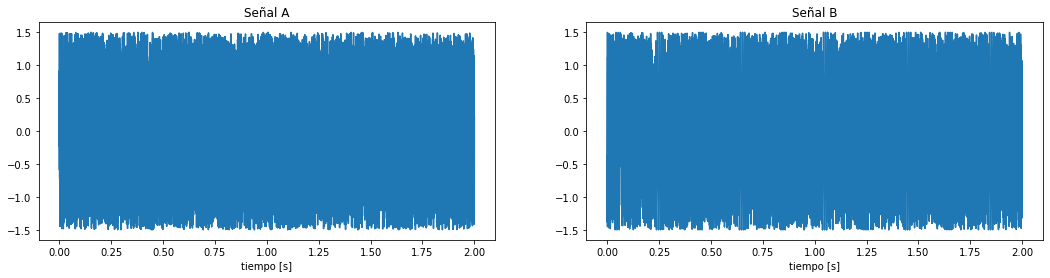

In [ ]:
#@title Definición de las señales del ejercicio
tiempo = np.linspace(0,2,10000)
xA = 3 * (np.random.rand(*tiempo.shape)-0.5) # señal A
xB = 3 * (np.random.rand(*tiempo.shape)-0.5) * np.where(np.sin(2*np.pi*5*tiempo) < 0.9, 1, 0) + np.where(np.sin(2*np.pi*5*tiempo) >= 0.9, 1.5 * np.sin(2*np.pi*100*tiempo), 0)# señal B # CAMBIAR EL SENO POR UN IMPACTO PERIÓDICO
fig = plt.figure(figsize=(18, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.plot(tiempo,xA)
ax2.plot(tiempo,xB)
ax1.set_xlabel('tiempo [s]'), ax1.set_title('Señal A')
ax2.set_xlabel('tiempo [s]'), ax2.set_title('Señal B');

Se pide:
* Calcula las funciones de autocorrelación para ambas señales.
* Haz dos gráficas mostrando ambas funciones.

In [ ]:
# Escribe en esta celda la solución

Análisis los resultados:
* ¿Puedes sacar algo de información sobre ambas señales a la vista únicamente de sus evoluciones temporales?

<font color="red">Escribe aquí tu respuesta</font>

* A la vista de la función de autocorrelación de la señal A, ¿qué tipo de señal parece ser?

<font color="red">Escribe aquí tu respuesta</font>

* A la vista de la función de autocorrelación de la señal B, ¿qué tipo de señal parece ser?

<font color="red">Escribe aquí tu respuesta</font>

* ¿Cuál es el valor de $\tau$ para el que la función de autocorrelación es máximo en ambas señales?

<font color="red">Escribe aquí tu respuesta</font>

* En la señal B, ¿para qué valores de $\tau$ la función de autocorrelación es relevante?

<font color="red">Escribe aquí tu respuesta</font>

* ¿Qué frecuencia corresponde con el primer valor máximo de $\tau$ distinto de cero? ¿Encuentras esa frecuencia en la definición de la señal (ver unas celdas más arriba)?

<font color="red">Escribe aquí tu respuesta</font>


### Ejercicio 4.2

Se trata de cuantificar el ruido producido por un taladro y que ha sido registrado con un micrófono.

Este ejercicio está muy relacionado con el Tema 2.- Cuantificación y Percepción pero se presenta ahora que ya se ha visto cómo realizar la Transformada de Fourier.

Hay algunos pasos del ejercicio que ya están hechos; otros los debes completar tú.

In [ ]:
#@title Lectura del fichero y obtención de información del mismo
# El fichero de texto tiene (lo puedes abrir en cualquier editor de texto si quieres comprobarlo):
# - 84 líneas al principio con información del ensayo (no nos interesa)
# - 3 columnas en el medio con número de medida, tiempo y presión (esta información es la que queremos)
# - 6 líneas finales con información del ensayo (no nos interesa)
# Vamos a leer el fichero con la función read_csv del módulo pandas y lo vamos a guardar en el objeto "datos":

# Descarga en el ordenador el audio
fichin = urllib.request.urlopen('https://hcliment.webs.upv.es/docencia/dar/sounds/tema04/Tiempo_taladro.txt') # descarga el fichero de Internet
with open('Tiempo_taladro.txt','wb') as fichout:
    fichout.write(fichin.read()) # guarda el fichero en el ordenador
datos = pd.read_csv("Tiempo_taladro.txt", skiprows=84, skipfooter=6 , sep='\t', encoding = "ISO-8859-1", names=['col1', 'col2', 'col3'], engine='python')
tiempo = datos['col2'].values # vamos a quedarnos con los valores de la columna 2 en una variable "tiempo"
senyal = datos['col3'].values # y la columna 3 en una variable "senyal"
N = len(senyal) # número de puntos
duracion = tiempo[N-1] - tiempo[0] # duración del ensayo: resta del tiempo final y el inicial
fs = N/duracion # Hz, frecuencia de muestreo
datos.head(5) # nos presenta las cinco primeras filas

,col1,col2,col3
0,1,0.000000,1.239110
1,2,0.000061,-2.155830
2,3,0.000122,-0.019810
3,4,0.000183,0.026845
4,5,0.000244,-2.055440


#### Apartado 4.2.A
Indica la duración del ensayo, el número de puntos registrados y la frecuencia de muestreo.

In [ ]:
#@title
# Información del archivo
print('Duración del ensayo: {0:.2f} segundos'.format(duracion))
print('Número de puntos registrados: {0:.0f} puntos'.format(N))
print('Frecuencia de muestreo: {0:.2f} Hz'.format(fs))

Duración del ensayo: 3.00 segundos
Número de puntos registrados: 49152 puntos
Frecuencia de muestreo: 16384.33 Hz


#### Apartado 4.2.B
Se pide:
* Representa gráficamente la señal temporal.
* Crea un objeto de audio para poder oírla.

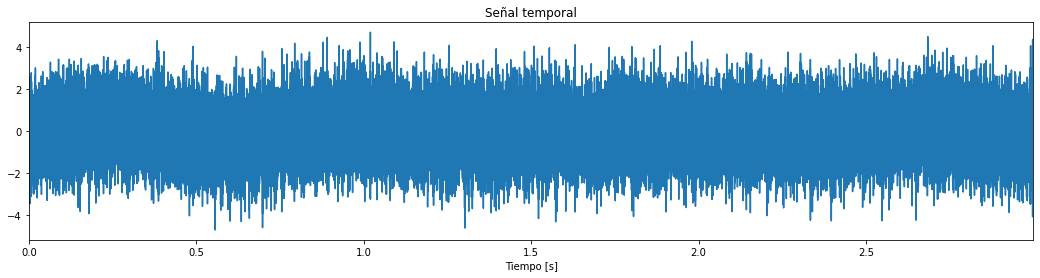

In [ ]:
#@title
# Escribe en esta celda la solución
fig = plt.figure(figsize=(18, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(tiempo, senyal)
ax1.set_xlim([0, duracion])
ax1.set_title('Señal temporal')
ax1.set_xlabel('Tiempo [s]')

# Venga, vamos a oírlo:
Audio(senyal, rate=fs)

#### Apartado 4.2.C
Se pide:
* Obtener el espectro en frecuencia de la señal y representarlo gráficamente (solo las frecuencias positivas).

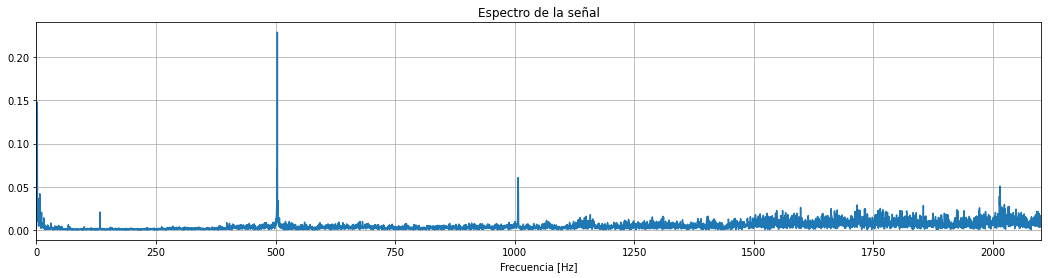

In [ ]:
#@title
# Escribe en esta celda la solución
tf_senyal = np.fft.fft(senyal)/N*2
tf_senyal[0] = tf_senyal[0]/2
fr_senyal = np.fft.fftfreq(N, 1/fs)
Nmitad = N//2 if N%2==0 else N//2+1
fig = plt.figure(figsize=(18, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(fr_senyal[0:Nmitad], np.abs(tf_senyal[0:Nmitad]))
ax1.set_title('Espectro de la señal')
ax1.set_xlabel('Frecuencia [Hz]')
ax1.set_xlim([0,2100])
ax1.grid();

#### Apartado 4.2.D

Se pide:
* Obtener un vector donde se vayan sumando las componentes del espectro (dos a dos).

<small>NOTA: Piensa lo que significa el espectro de la señal: en realidad se tiene la misma información que en dominio tiempo pero como si fuera una suma de multitud de senos a diferentes frecuencias (y cada una de ellas con su amplitud (de presión acústica) correspondiente). Se trata de diseñar algo de código para hacer un barrido de todas las frecuencias y sumar niveles de presión sonora de dos en dos como ya hicimos en los ejercicios del Tema 2.- Cuantificación y Percepción.</small>

Nivel de presión sonora: 100.53755854942341 dB


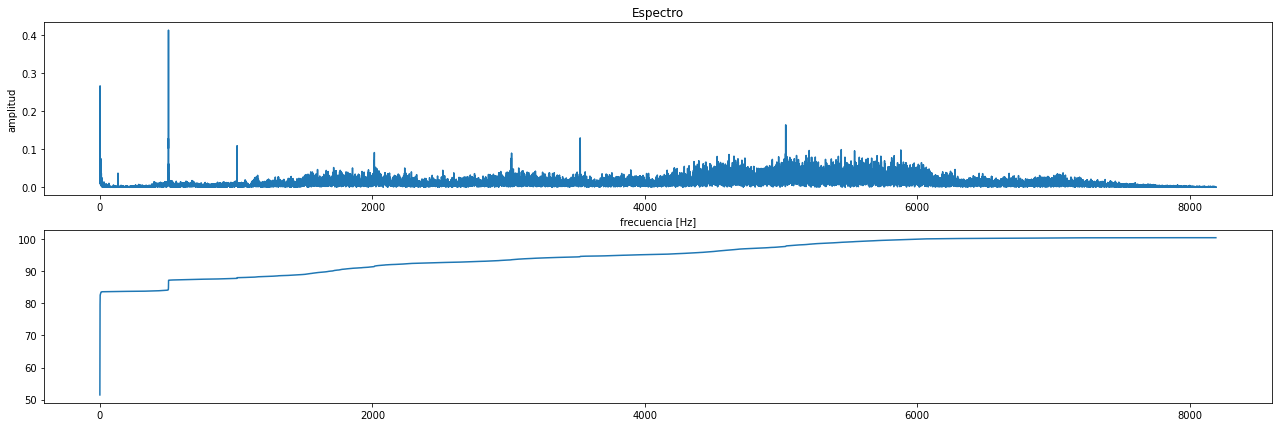

In [ ]:
#@title
# Escribe en esta celda la solución
COEFICIENTE_CALIBRACION = 1.8
tf_senyal = np.fft.fft(COEFICIENTE_CALIBRACION*senyal)/N*2
fr_senyal = np.fft.fftfreq(N, 1/fs)
Nmitad = N//2 if N%2==0 else N//2+1

amp_senyal = np.abs(tf_senyal) # amplitudes
rms_senyal = amp_senyal / np.sqrt(2) # valor RMS

p0 = 0.00002 # Pa (nivel de referencia)
dBacum = np.zeros([Nmitad])
for k in range(Nmitad):
    if k == 0:
        p1 = rms_senyal[k]
        dBacum[k] = 20 * np.log10(p1/p0) # primera componente (frecuencia); no sumamos nada; esta expresión ya la usaste en los ejercicios del Tema 2.- Cuantificación y Percepción
    else:
        # Obtenemos la presión acústica a partir del nivel de presión sonora acumulado hasta ahora:
        p1 = np.power(10, dBacum[k-1]/20) * p0
        # Y miramos el valor de la presión acústica de la siguiente componente (frecuencia)
        p2 = rms_senyal[k]
        # Sabemos que la intensidad acústica es proporcional al cuadrado de la presión acústica; esto también lo usaste en los ejercicios del Tema 2
        cte = 5 # es arbitrario este valor; puedes probar con otros que en este caso no cambia
        I1 = cte * np.power(p1, 2)
        I2 = cte * np.power(p2, 2)
        It = I1 + I2
        pt = np.power(It/cte, 0.5)
        dBacum[k] = 20 * np.log10(pt/p0)

fig = plt.figure(figsize=(22, 7))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(fr_senyal[0:Nmitad], np.abs(tf_senyal[0:Nmitad]))
ax2.plot(fr_senyal[0:Nmitad],dBacum)
print('Nivel de presión sonora: ' + str(dBacum[-1]) + ' dB')
ax1.set_title('Espectro')
ax1.set_xlabel('frecuencia [Hz]')
ax1.set_ylabel('amplitud');

In [ ]:
K_calibracion = 1
rms_senyal = np.sqrt(np.sum((K_calibracion*senyal)**2)/len(senyal))
p0 = 2e-5 # Pa
20 * np.log10(rms_senyal/p0)

95.43208237630589

In [ ]:
p0 = 0.00002 # Pa (nivel de referencia)
# De la definición de nivel de presión sonora:
p = np.sqrt(np.sum(senyal**2)/len(senyal))
Lp = 20 * np.log10(p/p0)
Lp

95.43208237630589

In [ ]:
tf_senyal[1]

(0.0273491050004974+0.03275351579902535j)

<h3>Apartado 4.2.E</h3>
<p>Se pide:</p>
<ul>
    <li>Obtener el espectro en tercios de octava y representarlo junto al espectro en banda estrecha en dos gráficas con escala diferente para el eje X: una lineal y otra  logarítmica.</li>
</ul>

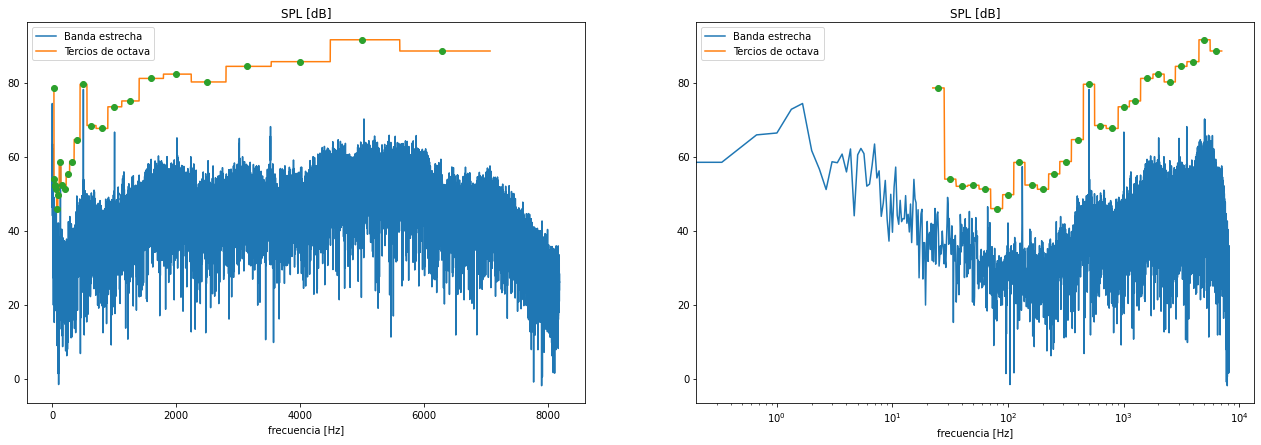

In [ ]:
# Este apartado está ya resuelto. Si no entiendes todo lo que está programado no pasa nada.
# De forma literaria, lo que se hace en esta celda es:
# - Volver a calcular el espectro continuo (banda estrecha); aunque no haría falta porque ya lo habíamos calculado en una celda anterior
# - Definir las frecuencias centrales normalizadas de los tercios de octava
# - Calcular las frecuencias de corte superiores de la banda y, a continuación, las inferiores
# - Hacer un barrido para todas las bandas y, en cada una de ellas:
# --- Realizar el cálculo de los decibelios (como en el apartado anterior) limitado a la banda de frecuencias que tengamos
# --- Actualizar el vector donde iremos guardando los resultados
# - Hacer la salida gráfica

tf_senyal = np.fft.fft(senyal)/N*2
fr_senyal = np.fft.fftfreq(N, 1/fs)
Nmitad = N//2 if N%2==0 else N//2+1

p0 = 0.00002 # Pa (nivel de referencia)

FrecNormCentralTercioOct = np.array([25, 31.5, 40, 50, 63, 80, 100, 125, 160, 200, 250, 315,
                                     400, 500, 630, 800, 1000, 1250, 1600, 2000, 2500, 3150,
                                     4000, 5000, 6300, 8000, 10000, 12500, 16000, 20000])
factor = np.power(2, 1.0/6.0)
FrecCorteHigh = FrecNormCentralTercioOct * factor
FrecCorteHigh = FrecCorteHigh[np.nonzero(FrecCorteHigh<fs/2)]
FrecCorteLow = np.roll(FrecCorteHigh,1)
FrecCorteLow[0] = 0
dBacumTercioOct = [] # incicializamos la lista (vector) donde guardaremos los dB de cada banda

for bandlow, bandhigh in zip(FrecCorteLow, FrecCorteHigh): # bucle para todas las bandas de tercio de octavas
    amp_senyal = np.abs(tf_senyal[np.nonzero((fr_senyal>bandlow) & (fr_senyal<bandhigh))]) # amplitudes solo de la banda en estudio
    rms_senyal = amp_senyal / np.sqrt(2) # valor RMS
    dBacum = 0
    for k in range(len(rms_senyal)-1): # bucle para todas las frecuencias de la banda en estudio
        if k == 0:
            p1 = rms_senyal[k]
            dBacum = 20 * np.log10(p1/p0) # primera componente (frecuencia)
        else:
            # Obtenemos la presión acústica a partir del nivel de presión sonora acumulado hasta ahora:
            p1 = np.power(10, dBacum/20) * p0
            # Y miramos el valor de la presión acústica de la siguiente componente (frecuencia)
            p2 = rms_senyal[k]
            # Sabemos que la intensidad acústica es proporcional al cuadrado de la presión acústica; esto también lo usaste en los ejercicios del Tema 2
            cte = 5 # es arbitrario este valor; puedes probar con otros que en este caso no cambia
            I1 = cte * np.power(p1, 2)
            I2 = cte * np.power(p2, 2)
            It = I1 + I2
            pt = np.power(It/cte, 0.5)
            dBacum = 20 * np.log10(pt/p0)
    dBacumTercioOct.append(dBacum) # añadimos el valor de los dB finales de la banda calculada a la lista (vector)

banda = 0
auxfTercio = []
auxdBTercio = []
for i in range(Nmitad):
    if fr_senyal[i] <= FrecCorteHigh[len(FrecCorteHigh)-1] and fr_senyal[i] >= FrecNormCentralTercioOct[0]/factor:
        if fr_senyal[i] > FrecCorteHigh[banda]:
            banda += 1
        auxfTercio.append(fr_senyal[i])
        auxdBTercio.append(dBacumTercioOct[banda])

fig = plt.figure(figsize=(22, 7))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(fr_senyal[0:Nmitad], 20 * np.log10(np.abs(tf_senyal[0:Nmitad])/np.sqrt(2)/p0), label='Banda estrecha')
ax1.plot(auxfTercio, auxdBTercio, label='Tercios de octava')
ax1.plot(FrecNormCentralTercioOct[:len(dBacumTercioOct)].tolist(), dBacumTercioOct,'o')
ax1.set_title('SPL [dB]')
ax1.set_xlabel('frecuencia [Hz]')
ax2 = fig.add_subplot(1, 2, 2)
ax2.semilogx(fr_senyal[0:Nmitad], 20 * np.log10(np.abs(tf_senyal[0:Nmitad])/np.sqrt(2)/p0), label='Banda estrecha')
ax2.semilogx(auxfTercio, auxdBTercio, label='Tercios de octava')
ax2.semilogx(FrecNormCentralTercioOct[:len(dBacumTercioOct)].tolist(), dBacumTercioOct,'o')
ax2.set_title('SPL [dB]')
ax2.set_xlabel('frecuencia [Hz]')
ax1.legend()
ax2.legend();


<h3>Apartado 4.2.F</h3>
<p>Se pide:</p>
<ul>
    <li>Obtener el espectro en octavas y representarlo junto al espectro en banda estrecha y en tercios de octava en dos gráficas con escala diferente para el eje X: una lineal y otra  logarítmica.</li>
</ul>


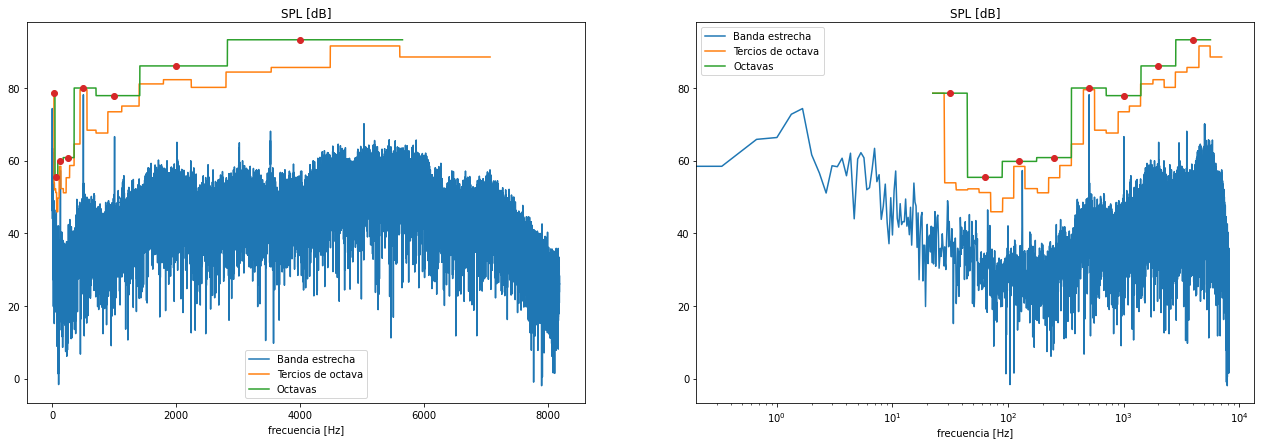

In [ ]:
# Este apartado está ya resuelto. Si no entiendes todo lo que está programado no pasa nada.
# De forma literaria, lo que se hace en esta celda es:
# - Volver a calcular el espectro continuo (banda estrecha); aunque no haría falta porque ya lo habíamos calculado en una celda anterior
# - Definir las frecuencias centrales normalizadas de los tercios de octava
# - Calcular las frecuencias de corte superiores de la banda y, a continuación, las inferiores
# - Hacer un barrido para todas las bandas y, en cada una de ellas:
# --- Realizar el cálculo de los decibelios (como en el apartado anterior) limitado a la banda de frecuencias que tengamos
# --- Actualizar el vector donde iremos guardando los resultados
# - Hacer la salida gráfica

tf_senyal = np.fft.fft(senyal)/N*2
fr_senyal = np.fft.fftfreq(N, 1/fs)
Nmitad = N//2 if N%2==0 else N//2+1

p0 = 0.00002 # Pa (nivel de referencia)

FrecNormCentralOct = np.array([31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000])
factor = np.power(2, 1.0/2.0)
FrecCorteHigh = FrecNormCentralOct * factor
FrecCorteHigh = FrecCorteHigh[np.nonzero(FrecCorteHigh<fs/2)]
FrecCorteLow = np.roll(FrecCorteHigh,1)
FrecCorteLow[0] = 0
dBacumOct = [] # incicializamos la lista (vector) donde guardaremos los dB de cada banda

for bandlow, bandhigh in zip(FrecCorteLow, FrecCorteHigh): # bucle para todas las bandas de tercio de octavas
    amp_senyal = np.abs(tf_senyal[np.nonzero((fr_senyal>bandlow) & (fr_senyal<bandhigh))]) # amplitudes solo de la banda en estudio
    rms_senyal = amp_senyal / np.sqrt(2) # valor RMS
    dBacum = 0
    for k in range(len(rms_senyal)-1): # bucle para todas las frecuencias de la banda en estudio
        if k == 0:
            p1 = rms_senyal[k]
            dBacum = 20 * np.log10(p1/p0) # primera componente (frecuencia)
        else:
            # Obtenemos la presión acústica a partir del nivel de presión sonora acumulado hasta ahora:
            p1 = np.power(10, dBacum/20) * p0
            # Y miramos el valor de la presión acústica de la siguiente componente (frecuencia)
            p2 = rms_senyal[k]
            # Sabemos que la intensidad acústica es proporcional al cuadrado de la presión acústica; esto también lo usaste en los ejercicios del Tema 2
            cte = 5 # es arbitrario este valor; puedes probar con otros que en este caso no cambia
            I1 = cte * np.power(p1, 2)
            I2 = cte * np.power(p2, 2)
            It = I1 + I2
            pt = np.power(It/cte, 0.5)
            dBacum = 20 * np.log10(pt/p0)
    dBacumOct.append(dBacum) # añadimos el valor de los dB finales de la banda calculada a la lista (vector)

banda = 0
auxfOct = []
auxdBOct = []
for i in range(Nmitad):
    if fr_senyal[i] <= FrecCorteHigh[len(FrecCorteHigh)-1] and fr_senyal[i] >= FrecNormCentralOct[0]/factor:
        if fr_senyal[i] > FrecCorteHigh[banda]:
            banda += 1
        auxfOct.append(fr_senyal[i])
        auxdBOct.append(dBacumOct[banda])

fig = plt.figure(figsize=(22, 7))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(fr_senyal[0:Nmitad], 20 * np.log10(np.abs(tf_senyal[0:Nmitad])/np.sqrt(2)/p0), label='Banda estrecha')
ax1.plot(auxfTercio, auxdBTercio, label='Tercios de octava')
ax1.plot(auxfOct, auxdBOct, label='Octavas')
ax1.plot(FrecNormCentralOct[:len(dBacumOct)].tolist(), dBacumOct,'o')
ax1.set_title('SPL [dB]')
ax1.set_xlabel('frecuencia [Hz]')
ax2 = fig.add_subplot(1, 2, 2)
ax2.semilogx(fr_senyal[0:Nmitad], 20 * np.log10(np.abs(tf_senyal[0:Nmitad])/np.sqrt(2)/p0), label='Banda estrecha')
ax2.semilogx(auxfTercio, auxdBTercio, label='Tercios de octava')
ax2.semilogx(auxfOct, auxdBOct, label='Octavas')
ax2.semilogx(FrecNormCentralOct[:len(dBacumOct)].tolist(), dBacumOct,'o')
ax2.set_title('SPL [dB]')
ax2.set_xlabel('frecuencia [Hz]')
ax1.legend()
ax2.legend();


#### Apartado 4.2.G
Con el fin de comparar la naturaleza acústica de diferentes señales, se pide repetir el ejercicio usando estas señales:
* Unas risas
* Un tren

<small>NOTA: A efectos prácticos lo único que cambia del ejercicio anterior es la definición de las señales (la celda anterior al apartado A); el resto de celdas serán idénticas.</small>

In [ ]:
#@title Lectura del fichero y obtención de información del mismo
# Descarga en el ordenador el audio
fichin = urllib.request.urlopen('https://hcliment.webs.upv.es/docencia/dar/sounds/tema04/risas_fs8192Hz.txt') # descarga el fichero de Internet
with open('risas_fs8192Hz.txt','wb') as fichout:
    fichout.write(fichin.read()) # guarda el fichero en el ordenador
# Esta celda lee una señal de unas risas (se sabe que el audio está muestreado a 8192 Hz)
datos = pd.read_csv("risas_fs8192Hz.txt", skiprows=0, skipfooter=0 , sep='\t', encoding = "ISO-8859-1", names=['col3'], engine='python')
fs = 8192 # Hz
senyal = datos['col3'].values
N = len(senyal)
duracion = N / fs
tiempo = np.linspace(0, duracion, N)
datos.head(5) # nos presenta las cinco primeras filas

,col3
0,-0.032958
1,-0.009568
2,0.029556
3,0.036360
4,0.012120


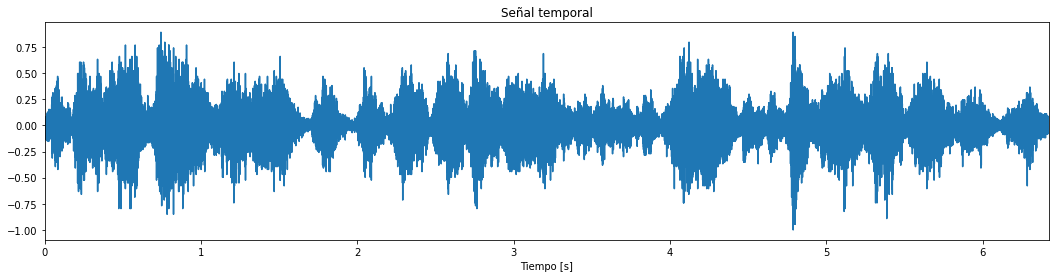

In [ ]:
#@title Representación en tiempo y su audio
# Escribe en esta celda la solución
fig = plt.figure(figsize=(18, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(tiempo, senyal)
ax1.set_xlim([0, duracion])
ax1.set_title('Señal temporal')
ax1.set_xlabel('Tiempo [s]')
# Venga, vamos a oírlo:
Audio(senyal, rate=fs)

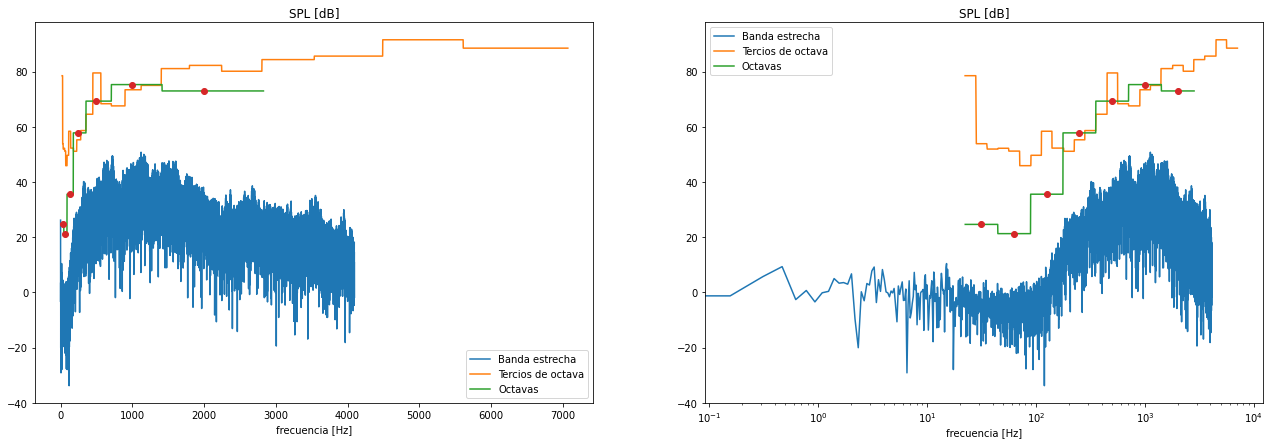

In [ ]:
#@title Representación en bandas
# Este apartado está ya resuelto. Si no entiendes todo lo que está programado no pasa nada.
# De forma literaria, lo que se hace en esta celda es:
# - Volver a calcular el espectro continuo (banda estrecha); aunque no haría falta porque ya lo habíamos calculado en una celda anterior
# - Definir las frecuencias centrales normalizadas de los tercios de octava
# - Calcular las frecuencias de corte superiores de la banda y, a continuación, las inferiores
# - Hacer un barrido para todas las bandas y, en cada una de ellas:
# --- Realizar el cálculo de los decibelios (como en el apartado anterior) limitado a la banda de frecuencias que tengamos
# --- Actualizar el vector donde iremos guardando los resultados
# - Hacer la salida gráfica

tf_senyal = np.fft.fft(senyal)/N*2
fr_senyal = np.fft.fftfreq(N, 1/fs)
Nmitad = N//2 if N%2==0 else N//2+1

p0 = 0.00002 # Pa (nivel de referencia)

FrecNormCentralOct = np.array([31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000])
factor = np.power(2, 1.0/2.0)
FrecCorteHigh = FrecNormCentralOct * factor
FrecCorteHigh = FrecCorteHigh[np.nonzero(FrecCorteHigh<fs/2)]
FrecCorteLow = np.roll(FrecCorteHigh,1)
FrecCorteLow[0] = 0
dBacumOct = [] # incicializamos la lista (vector) donde guardaremos los dB de cada banda

for bandlow, bandhigh in zip(FrecCorteLow, FrecCorteHigh): # bucle para todas las bandas de tercio de octavas
    amp_senyal = np.abs(tf_senyal[np.nonzero((fr_senyal>bandlow) & (fr_senyal<bandhigh))]) # amplitudes solo de la banda en estudio
    rms_senyal = amp_senyal / np.sqrt(2) # valor RMS
    dBacum = 0
    for k in range(len(rms_senyal)-1): # bucle para todas las frecuencias de la banda en estudio
        if k == 0:
            p1 = rms_senyal[k]
            dBacum = 20 * np.log10(p1/p0) # primera componente (frecuencia)
        else:
            # Obtenemos la presión acústica a partir del nivel de presión sonora acumulado hasta ahora:
            p1 = np.power(10, dBacum/20) * p0
            # Y miramos el valor de la presión acústica de la siguiente componente (frecuencia)
            p2 = rms_senyal[k]
            # Sabemos que la intensidad acústica es proporcional al cuadrado de la presión acústica; esto también lo usaste en los ejercicios del Tema 2
            cte = 5 # es arbitrario este valor; puedes probar con otros que en este caso no cambia
            I1 = cte * np.power(p1, 2)
            I2 = cte * np.power(p2, 2)
            It = I1 + I2
            pt = np.power(It/cte, 0.5)
            dBacum = 20 * np.log10(pt/p0)
    dBacumOct.append(dBacum) # añadimos el valor de los dB finales de la banda calculada a la lista (vector)

banda = 0
auxfOct = []
auxdBOct = []
for i in range(Nmitad):
    if fr_senyal[i] <= FrecCorteHigh[len(FrecCorteHigh)-1] and fr_senyal[i] >= FrecNormCentralOct[0]/factor:
        if fr_senyal[i] > FrecCorteHigh[banda]:
            banda += 1
        auxfOct.append(fr_senyal[i])
        auxdBOct.append(dBacumOct[banda])

fig = plt.figure(figsize=(22, 7))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(fr_senyal[0:Nmitad], 20 * np.log10(np.abs(tf_senyal[0:Nmitad])/np.sqrt(2)/p0), label='Banda estrecha')
ax1.plot(auxfTercio, auxdBTercio, label='Tercios de octava')
ax1.plot(auxfOct, auxdBOct, label='Octavas')
ax1.plot(FrecNormCentralOct[:len(dBacumOct)].tolist(), dBacumOct,'o')
ax1.set_title('SPL [dB]')
ax1.set_xlabel('frecuencia [Hz]')
ax2 = fig.add_subplot(1, 2, 2)
ax2.semilogx(fr_senyal[0:Nmitad], 20 * np.log10(np.abs(tf_senyal[0:Nmitad])/np.sqrt(2)/p0), label='Banda estrecha')
ax2.semilogx(auxfTercio, auxdBTercio, label='Tercios de octava')
ax2.semilogx(auxfOct, auxdBOct, label='Octavas')
ax2.semilogx(FrecNormCentralOct[:len(dBacumOct)].tolist(), dBacumOct,'o')
ax2.set_title('SPL [dB]')
ax2.set_xlabel('frecuencia [Hz]')
ax1.legend()
ax2.legend();


In [ ]:
#@title Lectura del fichero
# Descarga en el ordenador el audio
fichin = urllib.request.urlopen('https://hcliment.webs.upv.es/docencia/dar/sounds/tema04/tren_fs8192Hz.txt') # descarga el fichero de Internet
with open('tren_fs8192Hz.txt','wb') as fichout:
    fichout.write(fichin.read()) # guarda el fichero en el ordenador
# Esta celda lee una señal de un tren (se sabe que el audio está muestreado a 8192 Hz)
datos = pd.read_csv("tren_fs8192Hz.txt", skiprows=0, skipfooter=0 , sep='\t', encoding = "ISO-8859-1", names=['col3'], engine='python')
fs = 8192 # Hz
senyal = datos['col3'].values
N = len(senyal)
duracion = N / fs
tiempo = np.linspace(0, duracion, N)
datos.head(5) # nos presenta las cinco primeras filas

,col3
0,-0.030685
1,-0.001147
2,-0.010611
3,0.003441
4,0.014052


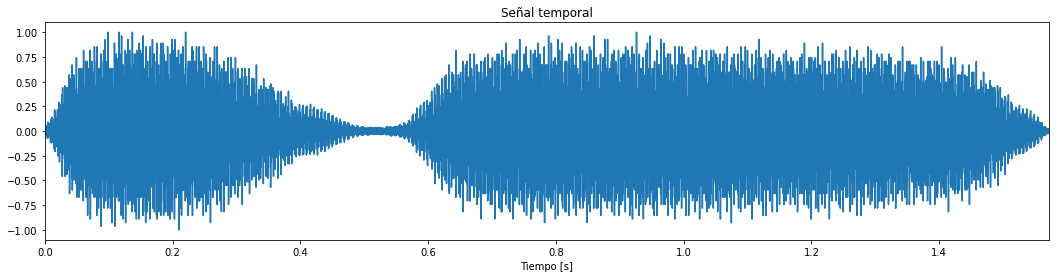

In [ ]:
#@title Representación en tiempo y su audio
# Escribe en esta celda la solución
fig = plt.figure(figsize=(18, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(tiempo, senyal)
ax1.set_xlim([0, duracion])
ax1.set_title('Señal temporal')
ax1.set_xlabel('Tiempo [s]')

# Venga, vamos a oírlo:
Audio(senyal, rate=fs)

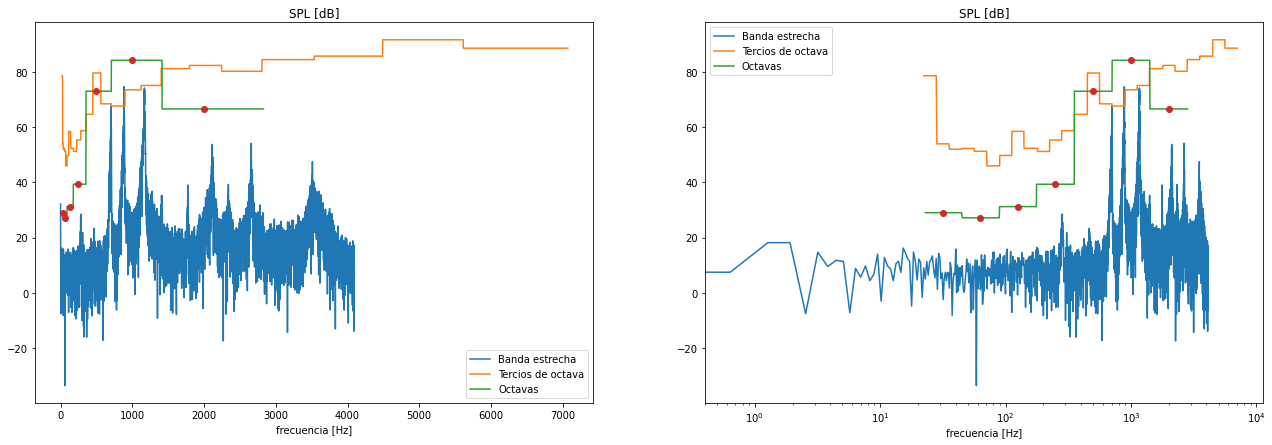

In [ ]:
#@title Representación en bandas
# Este apartado está ya resuelto. Si no entiendes todo lo que está programado no pasa nada.
# De forma literaria, lo que se hace en esta celda es:
# - Volver a calcular el espectro continuo (banda estrecha); aunque no haría falta porque ya lo habíamos calculado en una celda anterior
# - Definir las frecuencias centrales normalizadas de los tercios de octava
# - Calcular las frecuencias de corte superiores de la banda y, a continuación, las inferiores
# - Hacer un barrido para todas las bandas y, en cada una de ellas:
# --- Realizar el cálculo de los decibelios (como en el apartado anterior) limitado a la banda de frecuencias que tengamos
# --- Actualizar el vector donde iremos guardando los resultados
# - Hacer la salida gráfica

tf_senyal = np.fft.fft(senyal)/N*2
fr_senyal = np.fft.fftfreq(N, 1/fs)
Nmitad = N//2 if N%2==0 else N//2+1

p0 = 0.00002 # Pa (nivel de referencia)

FrecNormCentralOct = np.array([31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000])
factor = np.power(2, 1.0/2.0)
FrecCorteHigh = FrecNormCentralOct * factor
FrecCorteHigh = FrecCorteHigh[np.nonzero(FrecCorteHigh<fs/2)]
FrecCorteLow = np.roll(FrecCorteHigh,1)
FrecCorteLow[0] = 0
dBacumOct = [] # incicializamos la lista (vector) donde guardaremos los dB de cada banda

for bandlow, bandhigh in zip(FrecCorteLow, FrecCorteHigh): # bucle para todas las bandas de tercio de octavas
    amp_senyal = np.abs(tf_senyal[np.nonzero((fr_senyal>bandlow) & (fr_senyal<bandhigh))]) # amplitudes solo de la banda en estudio
    rms_senyal = amp_senyal / np.sqrt(2) # valor RMS
    dBacum = 0
    for k in range(len(rms_senyal)-1): # bucle para todas las frecuencias de la banda en estudio
        if k == 0:
            p1 = rms_senyal[k]
            dBacum = 20 * np.log10(p1/p0) # primera componente (frecuencia)
        else:
            # Obtenemos la presión acústica a partir del nivel de presión sonora acumulado hasta ahora:
            p1 = np.power(10, dBacum/20) * p0
            # Y miramos el valor de la presión acústica de la siguiente componente (frecuencia)
            p2 = rms_senyal[k]
            # Sabemos que la intensidad acústica es proporcional al cuadrado de la presión acústica; esto también lo usaste en los ejercicios del Tema 2
            cte = 5 # es arbitrario este valor; puedes probar con otros que en este caso no cambia
            I1 = cte * np.power(p1, 2)
            I2 = cte * np.power(p2, 2)
            It = I1 + I2
            pt = np.power(It/cte, 0.5)
            dBacum = 20 * np.log10(pt/p0)
    dBacumOct.append(dBacum) # añadimos el valor de los dB finales de la banda calculada a la lista (vector)

banda = 0
auxfOct = []
auxdBOct = []
for i in range(Nmitad):
    if fr_senyal[i] <= FrecCorteHigh[len(FrecCorteHigh)-1] and fr_senyal[i] >= FrecNormCentralOct[0]/factor:
        if fr_senyal[i] > FrecCorteHigh[banda]:
            banda += 1
        auxfOct.append(fr_senyal[i])
        auxdBOct.append(dBacumOct[banda])

fig = plt.figure(figsize=(22, 7))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(fr_senyal[0:Nmitad], 20 * np.log10(np.abs(tf_senyal[0:Nmitad])/np.sqrt(2)/p0), label='Banda estrecha')
ax1.plot(auxfTercio, auxdBTercio, label='Tercios de octava')
ax1.plot(auxfOct, auxdBOct, label='Octavas')
ax1.plot(FrecNormCentralOct[:len(dBacumOct)].tolist(), dBacumOct,'o')
ax1.set_title('SPL [dB]')
ax1.set_xlabel('frecuencia [Hz]')
ax2 = fig.add_subplot(1, 2, 2)
ax2.semilogx(fr_senyal[0:Nmitad], 20 * np.log10(np.abs(tf_senyal[0:Nmitad])/np.sqrt(2)/p0), label='Banda estrecha')
ax2.semilogx(auxfTercio, auxdBTercio, label='Tercios de octava')
ax2.semilogx(auxfOct, auxdBOct, label='Octavas')
ax2.semilogx(FrecNormCentralOct[:len(dBacumOct)].tolist(), dBacumOct,'o')
ax2.set_title('SPL [dB]')
ax2.set_xlabel('frecuencia [Hz]')
ax1.legend()
ax2.legend();


### Ejercicio 4.3.
Calcula la transformada de Fourier de la señal "adivinanza.wav".


#### Apartado 4.3.A
Muestra el audio de la señal e incluye también una figura con dos gráficas donde:
* En la gráfica de la izquierda muestra la evolución temporal de la señal
* En la gráfica de la derecha representa su transformada de Fourier


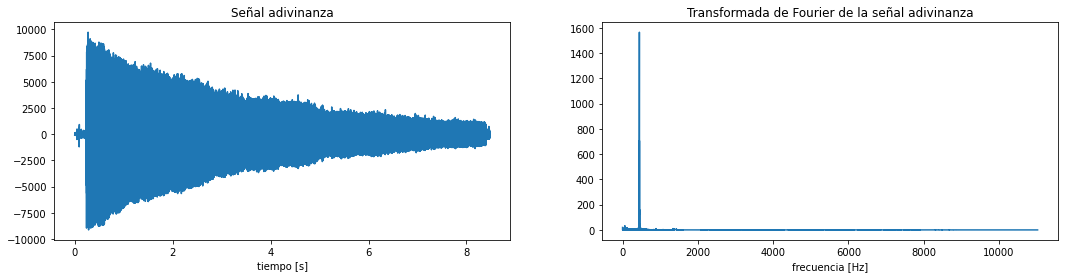

In [ ]:
#@title Lectura del fichero
# Descarga en el ordenador el audio
fichin = urllib.request.urlopen('https://hcliment.webs.upv.es/docencia/dar/sounds/tema04/adivinanza.wav') # descarga el fichero de Internet
with open('adivinanza.wav','wb') as fichout:
    fichout.write(fichin.read()) # guarda el fichero en el ordenador
# Lectura de un fichero de audio (en formato WAV)
fs, senyal = wavfile.read("adivinanza.wav")
if len(np.shape(senyal)) > 1:
    senyal = senyal[:, 0] # grabación en estéreo: nos quedamos con solo un canal
# Calculemos algunal cosas útiles:
N = len(senyal) # número de puntos de la señal. Ayuda: len()
tmax = N / fs # Ayuda: tmax = Npuntos x t_muestreo = Npuntos / f_muestreo
tiempo = np.linspace(0, tmax, N) # Creamos también el vector de tiempos, que nos hará falta después. Ayuda: np.linspace()
fig = plt.figure(figsize=(18, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(tiempo,senyal)
ax1.set_xlabel('tiempo [s]')
ax1.set_title('Señal adivinanza')
ax2 = fig.add_subplot(1, 2, 2)
tf_senyal = np.fft.fft(senyal)/N*2
fr_senyal = np.fft.fftfreq(N, 1/fs)
Nmitad = N//2 if N%2==0 else N//2+1
ax2.plot(fr_senyal[0:Nmitad], np.abs(tf_senyal[0:Nmitad]))
ax2.set_xlabel('frecuencia [Hz]')
ax2.set_title('Transformada de Fourier de la señal adivinanza');
# Venga, vamos a oír la señal adivinanza:
Audio(senyal, rate=fs)

#### Apartado 4.3.B
Análisis los resultados:
* ¿Qué información se puede sacar de la evolución temporal?

<font color="red">Escribe aquí tu respuesta</font>

* ¿Qué información se puede sacar del dominio frecuencial?

<font color="red">Escribe aquí tu respuesta</font>

* Por curiosidad, ¿sabrías identificar qué "máquina" genera ese "ruido"?

* <font color="red">Escribe aquí tu respuesta</font>


### Ejercicio 4.4.
Hagamos lo mismo para una señal un poco más divertida. Calcula la transformada de Fourier de la señal "ferrari355-freesound43484.wav".


#### Apartado 4.4.A
Muestra el audio de la señal e incluye también una figura con dos gráficas donde:
* En la gráfica superior muestra la evolución temporal de la señal
* En la gráfica inferior representa su transformada de Fourier


In [ ]:
#@title Lectura del fichero
# Descarga en el ordenador el audio
fichin = urllib.request.urlopen('https://hcliment.webs.upv.es/docencia/dar/sounds/tema04/ferrari355-freesound43484.wav') # descarga el fichero de Internet
with open('ferrari355-freesound43484.wav','wb') as fichout:
    fichout.write(fichin.read()) # guarda el fichero en el ordenador
fs, senyal = wavfile.read("ferrari355-freesound43484.wav")
if len(np.shape(senyal)) > 1:
    senyal = senyal[:, 0] # grabación en estéreo: nos quedamos con solo un canal
# Calculemos algunal cosas útiles:
N = len(senyal) # número de puntos de la señal. Ayuda: len()
tmax = N / fs # Ayuda: tmax = Npuntos x t_muestreo = Npuntos / f_muestreo
tiempo = np.linspace(0, tmax, N) # Creamos también el vector de tiempos, que nos hará falta después. Ayuda: np.linspace()
%matplotlib inline
fig = plt.figure(figsize=(22, 7))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(tiempo,senyal)
ax1.set_xlabel('tiempo [s]')
ax1.set_title('Señal temporal: Ferrari 355 (fuente: https://freesound.org/people/enginemusic/sounds/43484/)')
ax2 = fig.add_subplot(2, 1, 2)
tf_senyal = np.fft.fft(senyal)/N*2
fr_senyal = np.fft.fftfreq(N, 1/fs)
Nmitad = N//2 if N%2==0 else N//2+1
ax2.plot(fr_senyal[0:Nmitad], np.abs(tf_senyal[0:Nmitad]))
ax2.set_xlim([0, 1000])
ax2.set_title('Espectro')
ax2.set_xlabel('frecuencia [Hz]')
ax2.set_ylabel('amplitud');
# Venga, vamos a oír la señal adivinanza:
Audio(senyal, rate=fs)


Output hidden; open in https://colab.research.google.com to view.

#### Apartado 4.4.B
Análisis los resultados:
* ¿Qué información se puede sacar de la evolución temporal?

<font color="red">Escribe aquí tu respuesta</font>

* ¿Qué información se puede sacar del dominio frecuencial?

<font color="red">Escribe aquí tu respuesta</font>


### Ejercicio 4.5.
Ahora deberíamos <a href="https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html">aprender a seleccionar "trozos"</a> de una señal temporal. Vamos a repetir el ejercicio anterior con un trozo de señal donde el motor esté funcionando en estacionario (es decir, sin períodos de aceleraciones ni deceleraciones).

#### Apartado 4.5.A
Recorta la señal entre los segundos 3 y 4 (donde da la sensación de que el motor está a régimen de giro constante) y haz una figura con dos gráficas:
* En la gráfica superior muestra la evolución temporal de ese recorte de la señal
* En la gráfica inferior representa su transformada de Fourier junto con la del ejercicio anterior


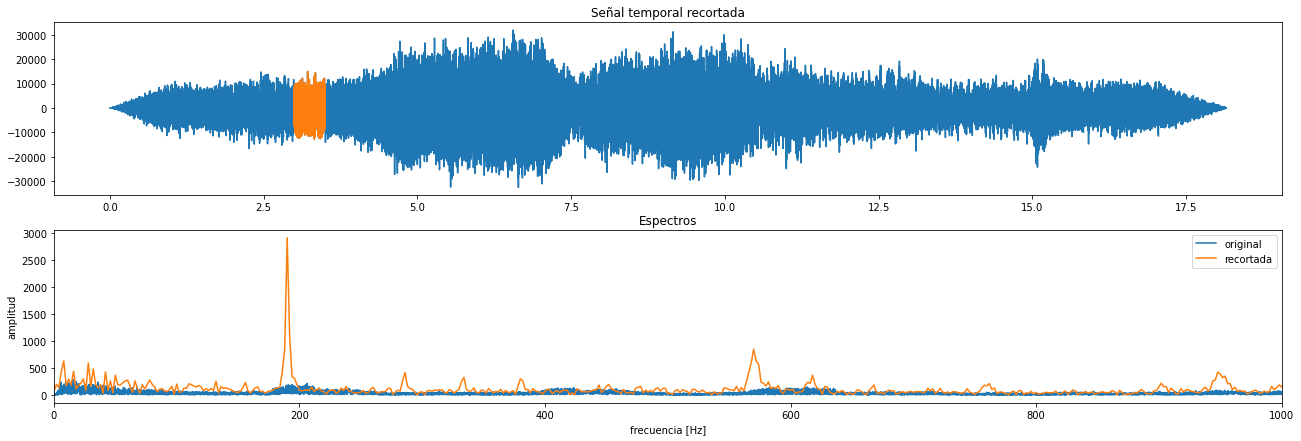

In [ ]:
#@title Lectura del fichero
# Descarga en el ordenador el audio
fichin = urllib.request.urlopen('https://hcliment.webs.upv.es/docencia/dar/sounds/tema04/ferrari355-freesound43484.wav') # descarga el fichero de Internet
with open('ferrari355-freesound43484.wav','wb') as fichout:
    fichout.write(fichin.read()) # guarda el fichero en el ordenador
fs, senyal = wavfile.read("ferrari355-freesound43484.wav")
if len(np.shape(senyal)) > 1:
    senyal = senyal[:, 0] # grabación en estéreo: nos quedamos con solo un canal
# Calculemos algunal cosas útiles:
N = len(senyal) # número de puntos de la señal. Ayuda: len()
tmax = N / fs # Ayuda: tmax = Npuntos x t_muestreo = Npuntos / f_muestreo
tiempo = np.linspace(0, tmax, N) # Creamos también el vector de tiempos, que nos hará falta después. Ayuda: np.linspace()
t_ini, t_fin = 3, 3.5
ind_ini = int(fs*t_ini)
ind_fin = int(fs*t_fin)
# Vamos a recortar la señal:
#senyal_rec = senyal[np.nonzero((tiempo>0.5) & (tiempo<1.5))] # comprender que nos estamos quedando con el trozo de señal entre 3 y 4 s no es evidente; esto ya es Python avanzado :)
senyal_rec = senyal[ind_ini:ind_fin] # comprender que nos estamos quedando con el trozo de señal entre 3 y 4 s no es evidente; esto ya es Python avanzado :)

N_rec = len(senyal_rec)
tmax_rec = N_rec / fs
tiempo_rec = np.linspace(0, tmax_rec, N_rec)

fig = plt.figure(figsize=(22, 7))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(tiempo,senyal)
ax1.plot(tiempo[ind_ini:ind_fin],senyal_rec)
ax1.set_title('Señal temporal recortada')
ax2 = fig.add_subplot(2, 1, 2)
tf_senyal = np.fft.fft(senyal)/N*2
fr_senyal = np.fft.fftfreq(N, 1/fs)
Nmitad = N//2 if N%2==0 else N//2+1

tf_senyal_rec = np.fft.fft(senyal_rec)/N_rec*2 # Calcula la transformada de Fourier. Ayuda: np.fft.fft()
fr_senyal_rec = np.fft.fftfreq(N_rec, 1/fs) # Calcula el vector de frecuencias. Ayuda: np.fft.fftfreq()
Nmitad_rec = N_rec//2 if N_rec%2==0 else N_rec//2+1

ax2.plot(fr_senyal[0:Nmitad], np.abs(tf_senyal[0:Nmitad]),label='original')
ax2.plot(fr_senyal_rec[0:Nmitad_rec], np.abs(tf_senyal_rec[0:Nmitad_rec]),label='recortada')
ax2.set_xlim([0, 1000])
ax2.legend()
ax2.set_title('Espectros')
ax2.set_xlabel('frecuencia [Hz]')
ax2.set_ylabel('amplitud');
# Venga, vamos a oír la señal:
Audio(senyal_rec, rate=fs)


#### Apartado 4.5.B
Análisis los resultados:
* Compara los espectros de la señal original (azul) y la recortada (naranja)
* Cambia en el código los tiempos que definen la señal recortada: *t_ini* y *t_fin*
* Selecciona tiempos donde el motor esté estabilizado y donde esté en funcionamiento transitorio. ¿Qué sucede en el espectro?

<font color="red">Escribe aquí tu respuesta</font>


<h2>Ejercicio 4.6.</h2>
<p>Genera una señal temporal de 0.5 s de duración y con 10000 puntos que esté compuesta por 3 senos con las siguientes características:</p>
<ul>
    <li>Seno 1: 3 de amplitud y 50 Hz de frecuencia</li>
    <li>Seno 2: 2 de amplitud y 250 Hz de frecuencia</li>
    <li>Seno 3: 1 de amplitud y 500 Hz de frecuencia</li>
</ul>

<h3>Apartado 4.6.A</h3>
<p>Se pide hacer una figura con cuatro gráficas (en la celda de abajo):</p>
<ul>
    <li>En la gráfica superior muestra la evolución temporal de la señal y filtrada usando un <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html">filtro Butterworth</a> de tercer orden, pasa-baja con una frecuencia de corte de 150 Hz</li>
    <li>En la segunda gráfica muestra la evolución temporal de la señal y filtrada usando un filtro Butterworth de tercer orden, pasa-banda con frecuencias de corte de 150 y 350 Hz</li>
    <li>En la tercera gráfica muestra la evolución temporal de la señal y filtrada usando un filtro Butterworth de tercer orden, pasa-alta con una frecuencia de corte de 350 Hz</li>
    <li>En la gráfica inferior muestra las transformadas de Fourier de las 4 señales (original y filtradas con cada filtro)</li>
</ul>


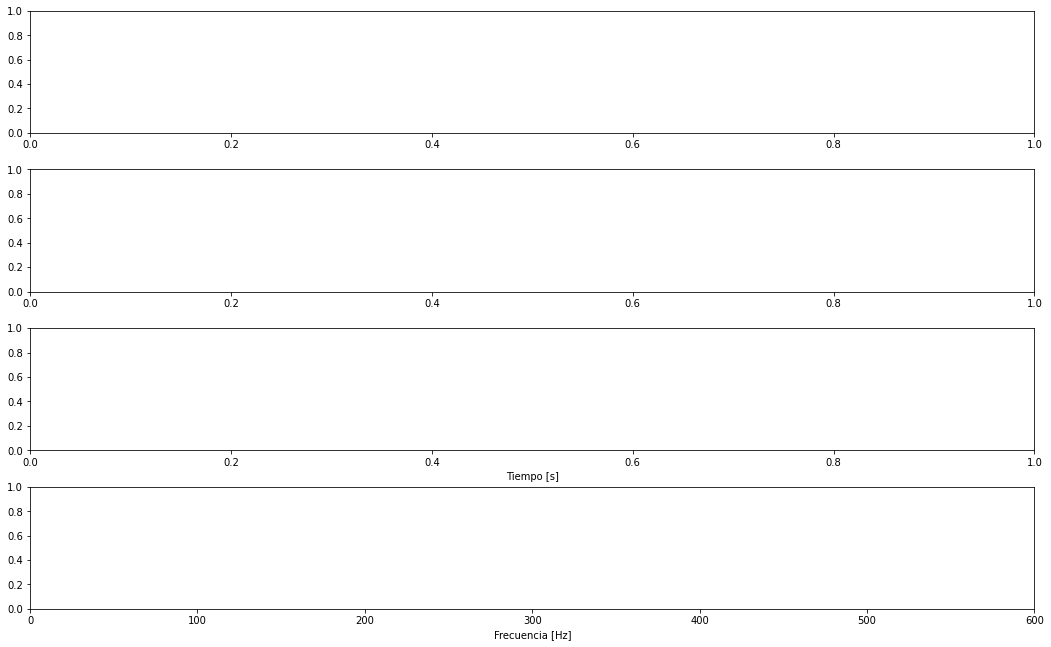

In [ ]:
# Escribe en esta celda la solución
# Diseñamos las señales

# Creación de los filtros:

# Aplicación de los filtros:

# Cálculo de las transformadas de Fourier

# Graficamos
fig = plt.figure(figsize=(18,11))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
ax1 = fig.add_subplot(4, 1, 1)
ax2 = fig.add_subplot(4, 1, 2)
ax3 = fig.add_subplot(4, 1, 3)
ax4 = fig.add_subplot(4, 1, 4)
ax4.set_xlim(0, 600)
ax3.set_xlabel('Tiempo [s]')
ax4.set_xlabel('Frecuencia [Hz]');

<p>Análisis los resultados:</p>
<ul>
    <li>¿Es razonable la transformada de Fourier de cada señal filtrada con su correspondiente filtro?</li>
</ul>
<p><font color="red">Escribe aquí tu respuesta</font></p>


<h3>Apartado 4.6.B</h3>
<p>Para estudiar el efecto del <a href="https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html">orden del filtro de Butterworth</a>, se pide hacer una figura con dos gráficas (en la celda de abajo):</p>
<ul>
    <li>En la gráfica superior muestra la evolución temporal de la señal original y al aplicar los filtros pasa-banda con frecuencias de corte de 150 y 350 Hz de primer, segundo y tercer orden.</li>
    <li>En la gráfica inferior muestra las transformadas de Fourier de las 4 señales (original y filtradas con cada orden)</li>
</ul>


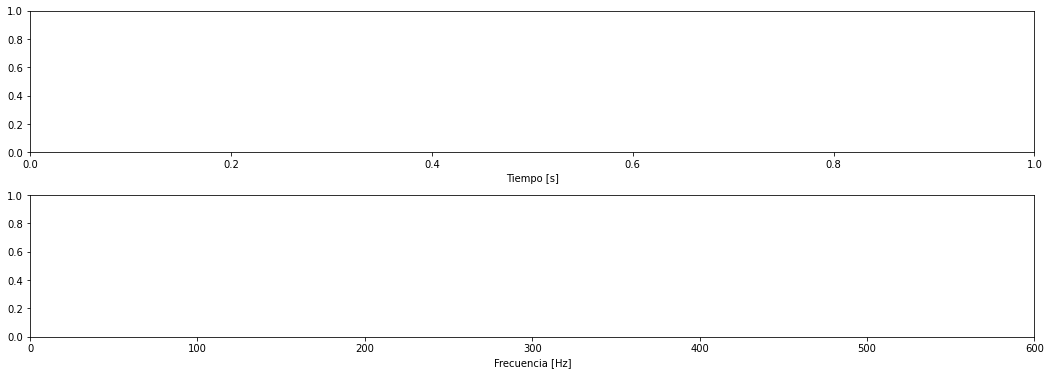

In [ ]:
# Escribe en esta celda la solución

# Creación de los filtros pasa-banda de primer, segundo y tercer orden:

# Aplicación de los filtros:

# Cálculo de las transformadas de Fourier

# Graficamos
fig = plt.figure(figsize=(18,6))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_xlim(0, 600)
ax1.set_xlabel('Tiempo [s]')
ax2.set_xlabel('Frecuencia [Hz]');

<p>Análisis los resultados:</p>
<ul>
    <li>Analiza la influencia del orden del filtro sobre la solución; en particular, observa qué sucede con la transformada de Fourier de las señales filtradas cuando se usan filtros pasa-banda de primer, segundo y tercer orden.</li>
</ul>
<p><font color="red">Escribe aquí tu respuesta</font></p>


### Ejercicio 4.7.
<img src="https://hcliment.webs.upv.es/docencia/dar/figs/tema04/test_de_juventud.jpg" alt="drawing" width="500"/>

Una vez me llegó este mensaje y pensé que podría ser un buen momento para analizar qué contenía ese fichero de audio. Se pide:
* Crear un objeto de audio e intenta escucharla. ¿Oyes algo?
* Representar la señal en dominio tiempo y frecuencia.
* ¿Puedes explicar por qué los niños sí lo escuchan y los mayores no? (NOTA: Recuerda el Tema de Percepción y Cuantificación)


In [ ]:
#@title Lectura del fichero
# Descarga en el ordenador el audio
fichin = urllib.request.urlopen('https://hcliment.webs.upv.es/docencia/dar/sounds/tema04/test_de_juventud.wav') # descarga el fichero de Internet
with open('test_de_juventud.wav','wb') as fichout:
    fichout.write(fichin.read()) # guarda el fichero en el ordenador
fs, senyal = wavfile.read("test_de_juventud.wav")
if len(np.shape(senyal)) > 1:
    senyal = senyal[:, 0] # grabación en estéreo: nos quedamos con solo un canal
# Calculemos algunal cosas útiles:
N = len(senyal) # número de puntos de la señal. Ayuda: len()
tmax = N / fs # Ayuda: tmax = Npuntos x t_muestreo = Npuntos / f_muestreo
tiempo = np.linspace(0, tmax, N) # Creamos también el vector de tiempos, que nos hará falta después. Ayuda: np.linspace()

# Cálculo de las transformadas de Fourier
tf_senyal = np.fft.fft(senyal)/N*2
frec = np.fft.fftfreq(N, 1/fs)
Nmitad = N//2 if N%2==0 else N//2+1

# Graficamos
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(tiempo, senyal, tiempo, senyal)
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(frec[0:Nmitad], np.abs(tf_senyal[0:Nmitad]))
ax1.set_xlabel('Tiempo [s]')
ax2.set_xlabel('Frecuencia [Hz]')
Audio(senyal, rate=fs)

Output hidden; open in https://colab.research.google.com to view.

**¿Qué debes haber aprendido al hacer los ejercicios?**
* A calcular funciones de autocorrelación y comprender su significado.
* A pasar una señal temporal al dominio de la frecuencia y representarla gráficamente.
* A leer información de un fichero de texto.
* A cargar la información de un fichero de audio en formato WAV.
* A recortar vectores.
* A diseñar filtros pasa-baja, pasa-alta y pasa-banda.
* A comprender la influencia del orden del filtro al filtrar señales.

## Fin del tema

## Anexo A: Espectro de la señal del micrófono en tiempo real
En este apartado se pretende desarrollar un cálculo del espectro de la señal capturada por el micrófono del ordenador en tiempo real. Si estás visualizando este Notebook en Google Colab no funcionará porque falla el acceso al dispositivo "micrófono" usando _pyaudio_ desde el navegador.

In [ ]:
#@title Importando pyaudio (no funciona en Google Colab, ver Anexo C)

"""
Notebook for streaming data from a microphone in realtime

audio is captured using pyaudio
then converted from binary data to ints using struct
then displayed using matplotlib

scipy.fftpack computes the FFT

if you don't have pyaudio, then run

>>> pip install pyaudio

note: with 2048 samples per chunk, I'm getting 20FPS
when also running the spectrum, its about 15FPS
"""

import pyaudio
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
import time

ModuleNotFoundError: ignored

In [ ]:
#@title Definiendo variables
# constants
CHUNK = 1024 * 4             # samples per frame
FORMAT = pyaudio.paInt16     # audio format (bytes per sample?)
CHANNELS = 1                 # single channel for microphone
RATE = 22500 #44100                 # samples per second
%matplotlib notebook

In [ ]:
#@title Espectro en tiempo real
# create matplotlib figure and axes
fig, (ax1, ax2) = plt.subplots(2, figsize=(7, 4))
plt.draw()
# pyaudio class instance
p = pyaudio.PyAudio()

# stream object to get data from microphone
stream = p.open(
    format=FORMAT,
    channels=CHANNELS,
    rate=RATE,
    input=True,
    output=True,
    frames_per_buffer=CHUNK
)

# variable for plotting
x = np.arange(0, 2 * CHUNK, 2)       # samples (waveform)
xf = np.linspace(0, RATE, CHUNK)     # frequencies (spectrum)

# create a line object with random data
line, = ax1.plot(x, np.random.rand(CHUNK), '-', lw=2)

# create semilogx line for spectrum
#line_fft, = ax2.semilogx(xf, np.random.rand(CHUNK), '-', lw=2)
line_fft, = ax2.plot(xf, np.random.rand(CHUNK), '-', lw=2)

# format waveform axes
ax1.set_title('AUDIO WAVEFORM')
ax1.set_xlabel('samples')
ax1.set_ylabel('volume')
#ax1.set_ylim(0, 255)
ax1.set_ylim(0, 1000)
ax1.set_xlim(0, 2 * CHUNK)
#plt.setp(ax1, xticks=[0, CHUNK, 2 * CHUNK], yticks=[0, 128, 255])

# format spectrum axes
# ax2.set_xlim(20, RATE / 2)
ax2.set_ylim(0, 2)
ax2.set_xlim(20, 4000)

print('stream started')

# for measuring frame rate
frame_count = 0
start_time = time.time()

#while True:
while frame_count<100:
    
    # binary data
    data = stream.read(CHUNK)
    # convert data to integers, make np array, then offset it by 127
    data_int = struct.unpack(str(2 * CHUNK) + 'B', data)
    
    # create np array and offset by 128
    data_np = np.array(data_int, dtype='b')[::2] + 128
    
    line.set_ydata(data_np)
    
    # compute FFT and update line
    yf = fft(data_int)
    line_fft.set_ydata(np.abs(yf[0:CHUNK])  / (128 * CHUNK))
    
    # update figure canvas
    fig.canvas.draw()
    fig.canvas.flush_events()
    frame_count += 1

print('stream finished')

## Anexo B: Grabación de la señal del micrófono (en WinPython)
Celdas útiles para realizar una grabación de la señal del micrófono. Si estás visualizando este Notebook en Google Colab no funcionará porque falla el acceso al dispositivo "micrófono" usando _pyaudio_ desde el navegador.

In [ ]:
#@title Cambia aquí la duración y el nombre del fichero

seconds = 10
fichero = "RecordingFromNotebook.wav"

import pyaudio
import wave

chunk = 1024  # Record in chunks of 1024 samples
sample_format = pyaudio.paInt16  # 16 bits per sample
channels = 1
fs = 44100  # Record at 44100 samples per second

p = pyaudio.PyAudio()  # Create an interface to PortAudio

print('Grabando...')

stream = p.open(format=sample_format,
                channels=channels,
                rate=fs,
                frames_per_buffer=chunk,
                input=True)

frames = []  # Initialize array to store frames

# Store data in chunks for 3 seconds
for i in range(0, int(fs / chunk * seconds)):
    data = stream.read(chunk)
    frames.append(data)

# Stop and close the stream 
stream.stop_stream()
stream.close()
# Terminate the PortAudio interface
p.terminate()

print('Fin de la grabación')

# Save the recorded data as a WAV file
wf = wave.open(fichero, 'wb')
wf.setnchannels(channels)
wf.setsampwidth(p.get_sample_size(sample_format))
wf.setframerate(fs)
wf.writeframes(b''.join(frames))
wf.close()

In [ ]:
#@title Muestra el audio grabado en la celda anterior

fs, x = read("RecordingFromNotebook.wav")
Audio(x,rate=fs)


## Anexo C: Grabación de la señal del micrófono (en Google Colab)
Celdas útiles para realizar una grabación de la señal del micrófono. Al contrario que en el anexo anterior, esto debería funcionar en Google Colab pero no en WinPython.

In [ ]:
#@title Importando los paquetes necesarios

from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#@title Definiendo las funciones y un poco de magia con Javascript
RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  senyal = np.array(audio.get_array_of_samples(), dtype=np.float32).reshape((-1, audio.channels)) / (
            1 << (8 * audio.sample_width - 1))
  return senyal.flatten(), audio.frame_rate

In [ ]:
#@title Realizando la grabación
t_rec = 3 # segundos
senyal, fs = record(t_rec)

In [ ]:
#@title Audio y representación en dominio tiempo y frecuencia
N = len(senyal) # número de puntos de la señal. Ayuda: len()
tmax = N / fs # Ayuda: tmax = Npuntos x t_muestreo = Npuntos / f_muestreo
tiempo = np.linspace(0, tmax, N) # Creamos también el vector de tiempos, que nos hará falta después. Ayuda: np.linspace()

# Cálculo de las transformadas de Fourier
tf_senyal = np.fft.fft(senyal)/N*2
frec = np.fft.fftfreq(N, 1/fs)
Nmitad = N//2 if N%2==0 else N//2+1

# Graficamos
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(tiempo, senyal, tiempo, senyal)
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(frec[0:Nmitad], np.abs(tf_senyal[0:Nmitad]))
ax1.set_xlabel('Tiempo [s]')
ax2.set_xlabel('Frecuencia [Hz]')
Audio(senyal, rate=fs)

## Anexo D: Calibración acústica de un móvil
Celdas útiles para realizar la calibración de un móvil a partir de las medidas realizadas en la cámara anecoica

Nivel de presión sonora (a partir del barrido de frecuencias y sumando de dos en dos): 77.6240054514979 dB
Nivel de presión sonora (a partir del valor RMS directamente en dominio tiempo): 77.6240039388112 dB


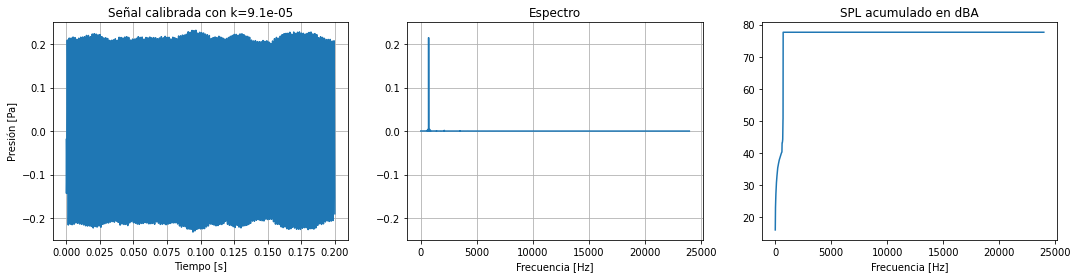

In [ ]:
#@title Calibración de un móvil con grabaciones en la cámara anecoica
# Descarga en el ordenador el audio
fichin = urllib.request.urlopen('https://hcliment.webs.upv.es/docencia/dar/sounds/tema04/700-Hz-77.6-dB.wav') # descarga el fichero de Internet
with open('700-Hz-77.6-dB.wav','wb') as fichout:
    fichout.write(fichin.read()) # guarda el fichero en el ordenador
fs, senyal = wavfile.read("700-Hz-77.6-dB.wav")
if len(np.shape(senyal)) > 1:
    senyal = senyal[:, 0] # grabación en estéreo: nos quedamos con solo un canal
# Recortamos la señal
senyal = senyal[int(1.2*fs):int(1.4*fs)]
# Obtención de los ceros, polos y ganancia de la ponderación A a partir de la función de transferencia en el dominio S
# https://en.wikipedia.org/wiki/A-weighting#Transfer_function_equivalent
z,p,k = sig.bilinear_zpk([0.0, 0.0, 0.0, 0.0], [-129.4, -129.4, -676.7, -4636.0, -76655.0, -76655.0], 7.39705E9, fs)
# Obtención de los coeficientes del filtro
b,a = sig.zpk2tf(z,p,k) #delivers 'ba' output
# Aplicación de la Ponderación A a la señal
senyal = sig.lfilter(b, a, senyal)
# Calculemos algunal cosas útiles:
N = len(senyal) # número de puntos de la señal. Ayuda: len()
tmax = N / fs # Ayuda: tmax = Npuntos x t_muestreo = Npuntos / f_muestreo
tiempo = np.linspace(0, tmax, N) # Creamos también el vector de tiempos, que nos hará falta después. Ayuda: np.linspace()

COEFICIENTE_CALIBRACION = 0.000091
# Ajustamos la ganancia
senyal = COEFICIENTE_CALIBRACION*senyal
p0 = 0.00002 # Pa (nivel de referencia)

rms_time = np.sqrt(np.mean(senyal**2))
db_time = 20 * np.log10(rms_time / p0)

tf_senyal = np.fft.fft(senyal)/N*2
fr_senyal = np.fft.fftfreq(N, 1/fs)
Nmitad = N//2 if N%2==0 else N//2+1

amp_senyal = np.abs(tf_senyal) # amplitudes
rms_senyal = amp_senyal / np.sqrt(2) # valor RMS

dBacum = np.zeros([Nmitad])
for k in range(Nmitad):
    if k == 0:
        p1 = rms_senyal[k]
        dBacum[k] = 20 * np.log10(p1/p0) # primera componente (frecuencia); no sumamos nada; esta expresión ya la usaste en los ejercicios del Tema 2.- Cuantificación y Percepción
    else:
        # Obtenemos la presión acústica a partir del nivel de presión sonora acumulado hasta ahora:
        p1 = np.power(10, dBacum[k-1]/20) * p0
        # Y miramos el valor de la presión acústica de la siguiente componente (frecuencia)
        p2 = rms_senyal[k]
        # Sabemos que la intensidad acústica es proporcional al cuadrado de la presión acústica; esto también lo usaste en los ejercicios del Tema 2
        cte = 5 # es arbitrario este valor; puedes probar con otros que en este caso no cambia
        I1 = cte * np.power(p1, 2)
        I2 = cte * np.power(p2, 2)
        It = I1 + I2
        pt = np.power(It/cte, 0.5)
        dBacum[k] = 20 * np.log10(pt/p0)

fig = plt.figure(figsize=(18, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
ax1.plot(tiempo, senyal)
ax2.plot(fr_senyal[0:Nmitad], np.abs(tf_senyal[0:Nmitad]))
ax3.plot(fr_senyal[0:Nmitad],dBacum)
for ax in [ax1, ax2]:
    ax.set_ylim([-0.25,0.25])
    ax.grid(True)
print('Nivel de presión sonora (a partir del barrido de frecuencias y sumando de dos en dos): ' + str(dBacum[-1]) + ' dB')
print('Nivel de presión sonora (a partir del valor RMS directamente en dominio tiempo): ' + str(db_time) + ' dB')
ax1.set_title('Señal calibrada con k={}'.format(COEFICIENTE_CALIBRACION))
ax2.set_title('Espectro')
ax3.set_title('SPL acumulado en dBA')
ax1.set_xlabel('Tiempo [s]')
ax2.set_xlabel('Frecuencia [Hz]')
ax3.set_xlabel('Frecuencia [Hz]')
ax1.set_ylabel('Presión [Pa]');

In [ ]:
# Otra forma de calcular el ruido: si solo hay una fuente, ¿recuerdas un ejercicio del Tema 2?
# Datos:
# Podemos obtener el valor de la amplitud a partir del máximo en el espectro: np.max(np.abs(tf_senyal[0:Nmitad]))
p = 0.21480733389254505/np.sqrt(2) # Pa; se divide la amplitud entre la raíz de 2 para tener el valor cuadrático medio de un seno (RMS)
p0 = 0.00002 # Pa (nivel de referencia)
# De la definición de nivel de presión sonora:
Lp = 20 * np.log10(p/p0)
print('Nivel de presión sonora: {0:.2f} dB'.format(Lp))

Nivel de presión sonora: 77.61 dB


Nivel de presión sonora (a partir del barrido de frecuencias y sumando de dos en dos): 81.07388124037696 dB
Nivel de presión sonora (a partir del valor RMS directamente en dominio tiempo): 81.07387988246059 dB


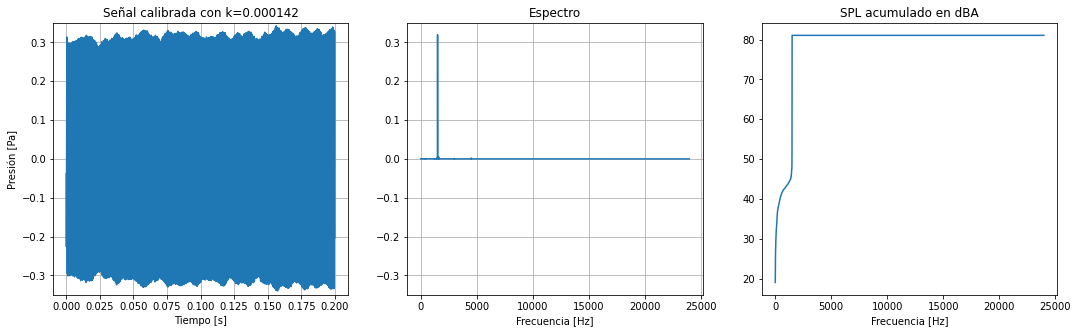

In [ ]:
#@title Calibración de un móvil con grabaciones en la cámara anecoica
# Descarga en el ordenador el audio
fichin = urllib.request.urlopen('https://hcliment.webs.upv.es/docencia/dar/sounds/tema04/1500-Hz-81.1-dB.wav') # descarga el fichero de Internet
with open('1500-Hz-81.1-dB.wav','wb') as fichout:
    fichout.write(fichin.read()) # guarda el fichero en el ordenador
fs, senyal = wavfile.read("1500-Hz-81.1-dB.wav")
if len(np.shape(senyal)) > 1:
    senyal = senyal[:, 0] # grabación en estéreo: nos quedamos con solo un canal
senyal = senyal[int(2.1*fs):int(2.3*fs)]
# Obtención de los ceros, polos y ganancia de la ponderación A a partir de la función de transferencia en el dominio S
# https://en.wikipedia.org/wiki/A-weighting#Transfer_function_equivalent
z,p,k = sig.bilinear_zpk([0.0, 0.0, 0.0, 0.0], [-129.4, -129.4, -676.7, -4636.0, -76655.0, -76655.0], 7.39705E9, fs)
# Obtención de los coeficientes del filtro
b,a = sig.zpk2tf(z,p,k) #delivers 'ba' output
# Aplicación del filtro
senyal = sig.lfilter(b, a, senyal)
# Calculemos algunal cosas útiles:
N = len(senyal) # número de puntos de la señal. Ayuda: len()
tmax = N / fs # Ayuda: tmax = Npuntos x t_muestreo = Npuntos / f_muestreo
tiempo = np.linspace(0, tmax, N) # Creamos también el vector de tiempos, que nos hará falta después. Ayuda: np.linspace()

COEFICIENTE_CALIBRACION = 0.000142
senyal = COEFICIENTE_CALIBRACION*senyal
p0 = 0.00002 # Pa (nivel de referencia)

rms_time = np.sqrt(np.mean(senyal**2))
db_time = 20 * np.log10(rms_time / p0)

tf_senyal = np.fft.fft(senyal)/N*2
fr_senyal = np.fft.fftfreq(N, 1/fs)
Nmitad = N//2 if N%2==0 else N//2+1

amp_senyal = np.abs(tf_senyal) # amplitudes
rms_senyal = amp_senyal / np.sqrt(2) # valor RMS

dBacum = np.zeros([Nmitad])
for k in range(Nmitad):
    if k == 0:
        p1 = rms_senyal[k]
        dBacum[k] = 20 * np.log10(p1/p0) # primera componente (frecuencia); no sumamos nada; esta expresión ya la usaste en los ejercicios del Tema 2.- Cuantificación y Percepción
    else:
        # Obtenemos la presión acústica a partir del nivel de presión sonora acumulado hasta ahora:
        p1 = np.power(10, dBacum[k-1]/20) * p0
        # Y miramos el valor de la presión acústica de la siguiente componente (frecuencia)
        p2 = rms_senyal[k]
        # Sabemos que la intensidad acústica es proporcional al cuadrado de la presión acústica; esto también lo usaste en los ejercicios del Tema 2
        cte = 5 # es arbitrario este valor; puedes probar con otros que en este caso no cambia
        I1 = cte * np.power(p1, 2)
        I2 = cte * np.power(p2, 2)
        It = I1 + I2
        pt = np.power(It/cte, 0.5)
        dBacum[k] = 20 * np.log10(pt/p0)

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
ax1.plot(tiempo, senyal)
ax2.plot(fr_senyal[0:Nmitad], np.abs(tf_senyal[0:Nmitad]))
ax3.plot(fr_senyal[0:Nmitad],dBacum)
for ax in [ax1, ax2]:
    ax.set_ylim([-0.35,0.35])
    ax.grid(True)
print('Nivel de presión sonora (a partir del barrido de frecuencias y sumando de dos en dos): ' + str(dBacum[-1]) + ' dB')
print('Nivel de presión sonora (a partir del valor RMS directamente en dominio tiempo): ' + str(db_time) + ' dB')
ax1.set_title('Señal calibrada con k={}'.format(COEFICIENTE_CALIBRACION))
ax2.set_title('Espectro')
ax3.set_title('SPL acumulado en dBA')
ax1.set_xlabel('Tiempo [s]')
ax2.set_xlabel('Frecuencia [Hz]')
ax3.set_xlabel('Frecuencia [Hz]')
ax1.set_ylabel('Presión [Pa]');

In [ ]:
# Otra forma de calcular el ruido: si solo hay una fuente, ¿recuerdas un ejercicio del Tema 2?
# Datos:
# Podemos obtener el valor de la amplitud a partir del máximo en el espectro: np.max(np.abs(tf_senyal[0:Nmitad]))
p = 0.31966460451971196/np.sqrt(2) # Pa; se divide la amplitud entre la raíz de 2 para tener el valor cuadrático medio de un seno (RMS)
p0 = 0.00002 # Pa (nivel de referencia)
# De la definición de nivel de presión sonora:
Lp = 20 * np.log10(p/p0)
print('Nivel de presión sonora: {0:.2f} dB'.format(Lp))

Nivel de presión sonora: 81.06 dB


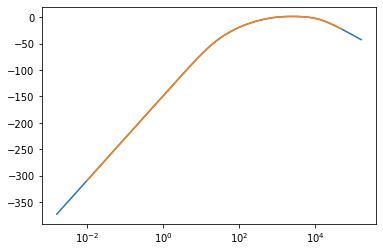

In [ ]:
# Comparación de la expresión de la Ponderación A vista en el Tema 2 (dBA vs. frecuencia) con la función de transferencia que aparece en la Wikipedia
def Pond_dBA(frec):
    aux1 = (1.562 * frec**4)/((frec**2+107.65**2) * (frec**2+737.86**2))
    aux2 = (2.243e16 * frec**4)/((frec**2+20.6**2)**2 * (frec**2+12194.22**2)**2)
    return 10*np.log10(aux1) + 10*np.log10(aux2)

# Obtención de los ceros, polos y ganancia de la ponderación A a partir de la función de transferencia en el dominio S
# https://en.wikipedia.org/wiki/A-weighting#Transfer_function_equivalent
system = sig.ZerosPolesGain([0.0, 0.0, 0.0, 0.0], [-129.4, -129.4, -676.7, -4636.0, -76655.0, -76655.0], 7.39705E9)
# Obtención de la respuesta en frecuencia del sistema
w, mag, phase = sig.bode(system)
plt.figure()
plt.semilogx(w/2/np.pi, mag) # a partir de la función de transferencia
f = np.linspace(1e-2,48000,10000)
plt.semilogx(f,Pond_dBA(f)); # a partir de la expresión vista en el Tema 2

In [ ]:
# Comprobación de la aplicación de la ponderación
# (esto solo se puede hacer en el caso de tener una única fuente, como es este caso)
print('Ponderación A a 700 Hz: {} dB'.format(Pond_dBA(700)))
print('Ponderación A a 1500 Hz: {} dB'.format(Pond_dBA(1500)))
dBsinPonderar700 = 79.01
dBsinPonderar1500 = 80.168
print('Señal a 700 Hz sin ponderación: {} dB'.format(dBsinPonderar700))
print('Señal a 1500 Hz sin ponderación: {} dB'.format(dBsinPonderar1500))
print('Señal a 700 Hz con ponderación A: {} dBA'.format(dBsinPonderar700+ Pond_dBA(700)))
print('Señal a 1500 Hz con ponderación A: {} dBA'.format(dBsinPonderar1500+ Pond_dBA(1500)))

Ponderación A a 700 Hz: -1.383748545735659 dB
Ponderación A a 1500 Hz: 0.9034307296817596 dB
Señal a 700 Hz sin ponderación: 79.01 dB
Señal a 1500 Hz sin ponderación: 80.168 dB
Señal a 700 Hz con ponderación A: 77.62625145426435 dBA
Señal a 1500 Hz con ponderación A: 81.07143072968177 dBA


## Anexo D: Enlaces interesantes

- https://github.com/peterbbryan/fourier-sketcher
